# Trabajo práctico - Aprendizaje Automático I

Integrantes:
- Garay Gorta, Isaías.
- Segui, Eduardo.


### Objetivo
Vamos a trabajar con el dataset `weatherAUS.csv` que contiene información sobre el clima de Australia en los últimos diez años. El objetivo es usar la información del dataset para predecir los atributos `RainTomorrow` y `RainfallTomorrow` con nuevos datos. Para esto vamos a utilizar modelos de regresión lineal, regresión logística y redes neuronales.

# Análisis exploratorio y limpieza de datos

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import shap

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from imblearn.over_sampling import SMOTE
from keras.models import load_model
from math import sqrt
import os

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
import optuna

import warnings
warnings.simplefilter('ignore')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2023-12-07 15:02:41.760895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 15:02:41.760926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 15:02:41.761591: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 15:02:41.766349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 15:02:42.440596: W tensorflow/compiler/tf2

In [2]:
df_original = pd.read_csv('datasets/weatherAUS.csv', index_col=0)

# Columnas

* **Sunshine:** Numero de horas de sol en el dia
* **Rainfall:** Cantidad de lluvia en el dia en mm
* **Evaporation:** La denominada evaporación del recipiente Clase A (mm) en el período de 24 horas a las 9 a.m.
* **WindGustDir:** La dirección de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche
* **WindGustSpeed:** La velocidad (km/h) de la ráfaga de viento más fuerte en las 24 horas previas a la medianoche
* **WindDir9am:** Dirección del viento a las 9 a.m.
* **WindDir3pm:** direccion del viento alas 3pm
* **WindSpeed9am:** Velocidad del viento (km/h) promediada durante 10 minutos antes de las 9 a.m.
* **WindSpeed3pm:** Velocidad del viento (km/h) promediada durante 10 minutos antes de las 3 p.m.
* **Humidity9am:** Humedad (porcentaje) a las 09:00 horas.
* **Humidity3pm:** Humedad (porcentaje) a las 15:00 horas.
* **Pressure9am:** La presión atmosférica (hpa) se redujo al nivel medio del mar a las 9 a.m.
* **Pressure3pm:** La presión atmosférica (hpa) se redujo al nivel medio del mar a las 3 p.m.
* **Cloud9am:** Fracción del cielo oscurecida por las nubes a las 9:00 horas. Esto se mide en "oktas", que son una unidad de octavos. Registra cuántas octavas partes del cielo están oscurecidas por las nubes. Una medida 0 indica cielo completamente despejado mientras que un 8 indica que está completamente nublado.
* **Cloud3pm:**
* **Temp9am:** Temperatura (grados C) a las 9 a.m.
* **Temp3pm:**
* **RainToday:** Booleano: 1 si la precipitación (mm) en las 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0
* **RainTomorrow:** La cantidad de lluvia del día siguiente en mm. Se utiliza para crear la variable de respuesta RainTomorrow. Una especie de medida del "riesgo".
* **RainfallTomorrow:** Variable booleana, indica si el día siguiente va a llover o no.

Para entrenar los modelos solamente vamos a usar cinco ciudades del dataset

In [3]:
ciudades = ['Sydney',
            'SydneyAirport',
            'Canberra',
            'Melbourne',
            'MelbourneAirport']

df = df_original[df_original['Location']\
                 .isin(ciudades)]\
                 .copy()\
                 .reset_index(drop=True)

Ordenamos el dataframe por localidad y fecha porque vamos a usar el metodo de la interpolacion lienal para llenar valores faltantes y tambien el metodo de valor mas cercano valido. 

In [4]:
df.sort_values(['Location', 'Date'], inplace=True)

Imputamos los datos que no son medidas estadicas antes de separar el dataset

## MinTemp y MaxTemp

Para estas variables decidimos usar una interpolación, ya que la temperatura de los días faltantes probablemente se encuentre en algún punto entre la temperatura del día anterior y la del día posterior.

In [5]:
df['MinTemp'].interpolate(method='linear', inplace=True)
df['MaxTemp'].interpolate(method='linear', inplace=True)

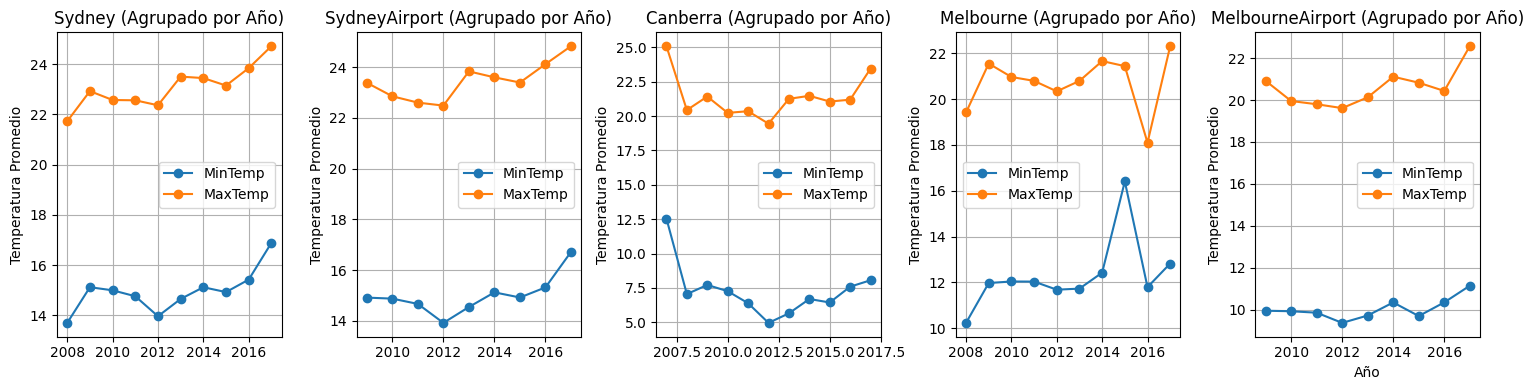

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

fig, axs = plt.subplots(1, 5, figsize=(15, 4))  

for i, ciudad in enumerate(ciudades):
    df_ciudad = df[df['Location'] == ciudad]
    df_ciudad['Year'] = df_ciudad['Date'].dt.year 

    df_grouped = df_ciudad[['Year', 'MinTemp', 'MaxTemp']].groupby('Year').mean().reset_index()
    
    axs[i].plot(df_grouped['Year'], df_grouped['MinTemp'], label='MinTemp', marker='o')
    axs[i].plot(df_grouped['Year'], df_grouped['MaxTemp'], label='MaxTemp', marker='o')
    axs[i].set_title(f'{ciudad} (Agrupado por Año)')
    axs[i].set_ylabel('Temperatura Promedio')
    axs[i].grid(True)
    axs[i].legend()

plt.xlabel('Año')
plt.tight_layout()
plt.show()

En los gráficos vemos que las temperaturas promedio por años de cada localidad siguen un comportamiento estable sin grandes saltos, por lo tanto consideramos que imputar estos datos con interpolación fue una buena decisión.

## WindDir 

Para la direcciones viento elegimos llenarla con el valor siguiente válido ya que es dataset está ordenado por fecha.

In [7]:
df['WindDir9am'].fillna(method='ffill', inplace=True)
df['WindDir3pm'].fillna(method='ffill', inplace=True)

## RainToday y RainTomorrow

Los valores Nan de estas dos variables son muy pocos y difíciles de imputar por eso decidimos eliminarlos.

In [8]:
df.RainToday.isna().sum(), df.RainTomorrow.isna().sum()

(787, 787)

In [9]:
df.dropna(subset=['RainTomorrow'], inplace=True)
df.dropna(subset=['RainToday'], inplace=True)

# Split del dataset

Separamos el dataset para en entrenamiento y prueba

In [10]:
x_reg = df.drop(columns=['RainTomorrow', 'RainfallTomorrow'])
y_reg = df['RainfallTomorrow']

x_clas = x_reg
y_clas = df['RainTomorrow']

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.2, random_state=42)
x_train_clas, x_test_clas, y_train_clas, y_test_clas = train_test_split(x_clas, y_clas, test_size=0.2, random_state=42)

In [11]:
df_reg  = pd.concat([x_train_reg, y_train_reg], axis=1)
df_clas = pd.concat([x_train_clas, y_train_clas], axis=1)

# ¿Está balanceado el dataset?

### Dataset regresión

El dataset no está balanceado porque la variable independietne que queremos predecir tiene muchos valores iguales a $0$.

<Axes: >

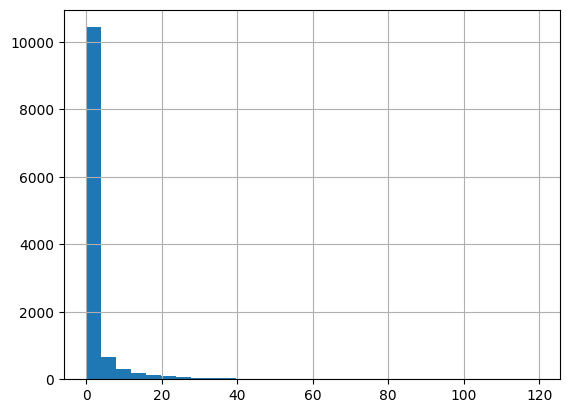

In [12]:
y_train_reg.hist(bins=30)

In [13]:
y_train_reg.shape

(12028,)

In [14]:
y_train_reg.value_counts()

RainfallTomorrow
0.0     7743
0.2      666
0.4      327
0.6      231
0.8      152
        ... 
41.8       1
54.4       1
40.6       1
57.8       1
53.0       1
Name: count, Length: 261, dtype: int64

In [15]:
f'{7784/12788:.2f}'

'0.61'

En el histograma vemos gráficamente que el dataset está desbalanceado, ya que la moda es $0$ y con los valores vemos que aproximadamente el $61\%$ de los valores de la variable a predecir son $0$.

### Dataset clasificación

<Axes: >

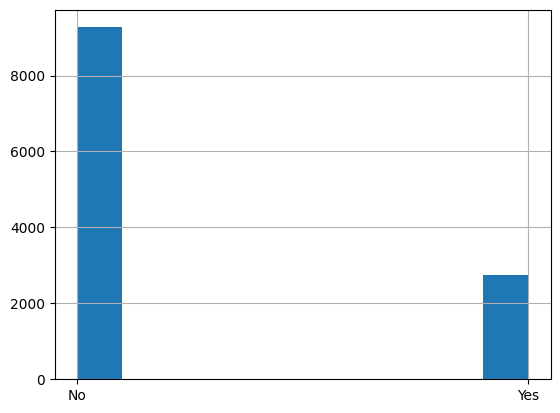

In [16]:
y_train_clas.hist()

In [17]:
y_train_clas.shape

(12028,)

In [18]:
y_train_clas.value_counts()

RainTomorrow
No     9270
Yes    2758
Name: count, dtype: int64

In [19]:
f'{9337/12788:.2f}'

'0.73'

Para el caso del dataset que usaremos para la clasificación también vemos que hay un importante desbalanceo, ya que el $73\%$ de sus valores pertenecen a una de las clases.

# Imputación de datos

## WindGustDir 

Esta variable en un momento habíamos decidido eliminarla (tenía un años con valores `nan`) pero ahora creemos que es mejor llenarla con la moda en función a la localidad y estación del año. 

In [20]:
df_modelos = [df_reg, df_clas, x_test_reg, x_test_clas]

def agregar_fecha(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Month'] = dataframe['Date'].dt.month

for dataframe in df_modelos:
    agregar_fecha(dataframe)

Estaciones en Australia
- Otoño: del 1 de marzo al 31 de mayo
- Invierno: del 1 de junio al 31 de agosto
- Primavera: del 1 de septiembre al 30 de noviembre
- Verano: del 1 de diciembre al 28 (ó 29) de febrero

In [21]:
estaciones_dict = {1:  'Verano',
                   2:  'Verano',
                   3:  'Otoño',
                   4:  'Otoño',
                   5:  'Otoño',
                   6:  'Invierno',
                   7:  'Invierno',
                   8:  'Invierno',
                   9:  'Primavera',
                   10: 'Primavera',
                   11: 'Primavera',
                   12: 'Verano'}

for dataframe in df_modelos:
    dataframe['Estacion'] = dataframe['Month'].map(estaciones_dict)

In [22]:
def temporada_ubicacion(df, columna_a_rellenar, columna_ubicacion, columna_temporada):
    
    moda_por_ubicacion_temporada = df.groupby([columna_ubicacion, columna_temporada])[columna_a_rellenar]\
                                     .apply(lambda x: x.mode().iloc[0])

    df[columna_a_rellenar] = df.apply(
        lambda fila: moda_por_ubicacion_temporada[fila[columna_ubicacion],
                                                  fila[columna_temporada]] 
                                                if pd.isna(fila[columna_a_rellenar]) 
                                                else fila[columna_a_rellenar],
        axis=1)

    return df

In [23]:
for dataframe in df_modelos:
    dataframe = temporada_ubicacion(dataframe, 
                                    'WindGustDir',
                                    'Location',
                                    'Estacion')

Ahora que imputamos todas los puntos cardinales de los datasets, vamos a asignarles a cada una de ellas un valor númerico que representa el grado correspondiente.

In [24]:
# Mapeo de puntos cardinales

coord = {
    'N': 0, 'E': 90, 'S': 180, 'W': 270,
    'WNW': 292.5, 'WSW': 247.5, 'NE': 45,
    'NNW': 337.5, 'NNE': 22.5, 'SW': 225,
    'ENE': 67.5, 'SSE': 157.5, 'NW': 315,
    'SE': 135, 'ESE': 112.5, 'SSW': 202.5
}

for dataframe in df_modelos:
    dataframe['WindGustDir'] = dataframe['WindGustDir'].map(coord)
    dataframe['WindDir9am'] = dataframe['WindDir9am'].map(coord)
    dataframe['WindDir3pm'] = dataframe['WindDir3pm'].map(coord)

## Rainfall

Para completar la variable `Rainfall` vamos a usar la moda de la distribución que es `0.0`, eso lo podemos comprobar con el siguiente histograma y loop.

Text(0.5, 1.0, 'Dataset Clasificación')

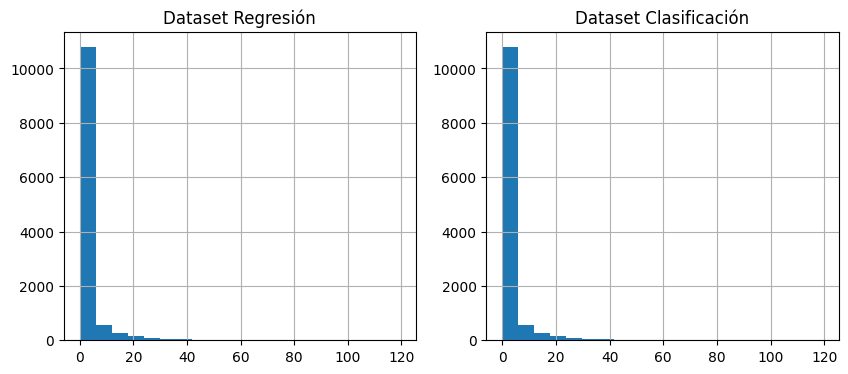

In [25]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
df_reg['Rainfall'].hist(bins=20)
plt.title('Dataset Regresión')
plt.subplot(122)
df_clas['Rainfall'].hist(bins=20)
plt.title('Dataset Clasificación')

In [26]:
for ciudad in ciudades:
    rain = \
        df_reg[df_reg['Location'] == ciudad]['Rainfall'].mode()[0]
    print(f'{ciudad + ":":17} {rain}')

Sydney:           0.0
SydneyAirport:    0.0
Canberra:         0.0
Melbourne:        0.0
MelbourneAirport: 0.0


In [27]:
for ciudad in ciudades:
    rain = \
        df_clas[df_clas['Location'] == ciudad]['Rainfall'].mode()[0]
    print(f'{ciudad + ":":17} {rain}')

Sydney:           0.0
SydneyAirport:    0.0
Canberra:         0.0
Melbourne:        0.0
MelbourneAirport: 0.0


In [28]:
df_reg['Rainfall'].fillna(0.0, inplace=True)
df_clas['Rainfall'].fillna(0.0, inplace=True)

## Evaporation

En esta variable vemos que la distribución es bastante simétrica, además la media y la mediana tiene valores muy cercanos, en esta caso no hay sesgo, por lo tanto decidimos completar los valores faltante con la media.

Text(0.5, 1.0, 'Dataset Clasificación')

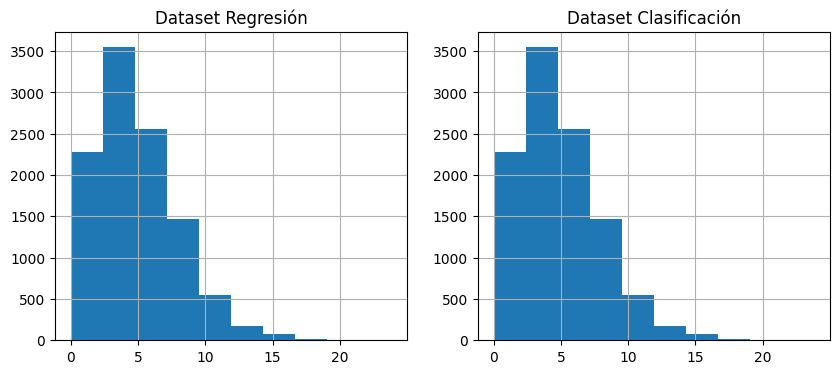

In [29]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
df_reg['Evaporation'].hist()
plt.title('Dataset Regresión')
plt.subplot(122)
df_clas['Evaporation'].hist()
plt.title('Dataset Clasificación')

In [30]:
df_reg['Evaporation'].mean(), df_reg['Evaporation'].median()

(4.873762051858092, 4.2)

In [31]:
df_clas['Evaporation'].mean(), df_clas['Evaporation'].median()

(4.873762051858092, 4.2)

In [32]:
df_reg['Evaporation'].fillna(df_reg['Evaporation'].mean(), inplace=True)
df_clas['Evaporation'].fillna(df_clas['Evaporation'].mean(), inplace=True)

## Sunshine

En este histograma vemos que la distribución es bimodal, por lo que para imputar los valores faltantes vamos usar la mediana, ya que la media está sesgada por la gran cantidad de `0.0`

Text(0.5, 1.0, 'Dataset Clasificación')

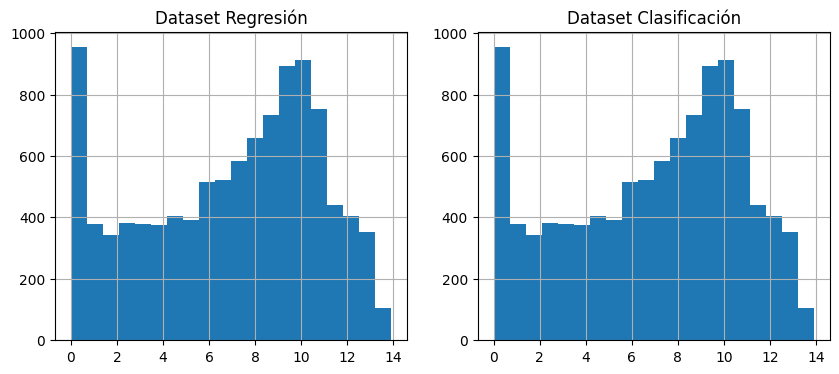

In [33]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
df_reg['Sunshine'].hist(bins=20)
plt.title('Dataset Regresión')
plt.subplot(122)
df_clas['Sunshine'].hist(bins=20)
plt.title('Dataset Clasificación')

In [34]:
df_reg['Sunshine'].fillna(df_reg['Sunshine'].median(), inplace=True)
df_clas['Sunshine'].fillna(df_clas['Sunshine'].median(), inplace=True)

## WindSpeed

En este caso observando los histogramas vemos que podemos completar los valores faltantes con la media.

Text(0.5, 1.0, 'Clasificación - WindSpeed3pm')

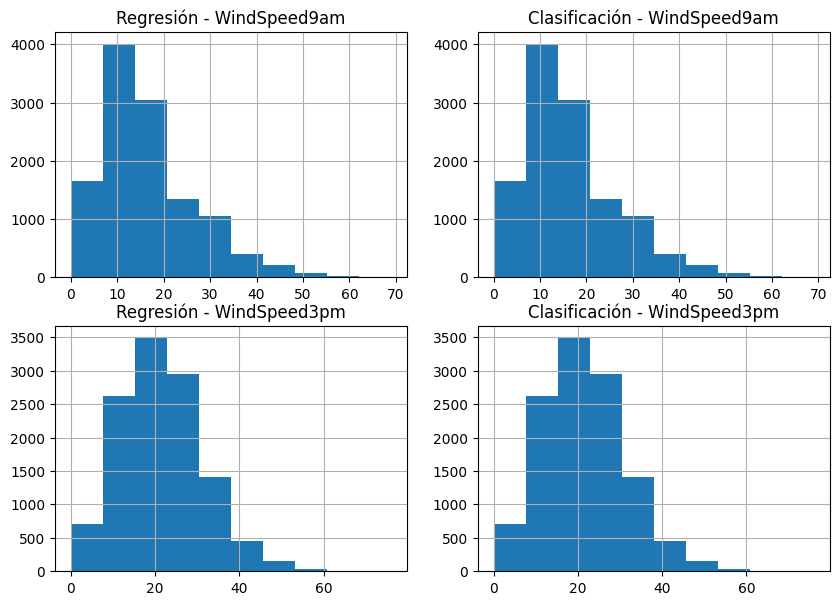

In [35]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['WindSpeed9am'].hist()
plt.title('Regresión - WindSpeed9am')
plt.subplot(222)
df_clas['WindSpeed9am'].hist()
plt.title('Clasificación - WindSpeed9am')
plt.subplot(223)
df_reg['WindSpeed3pm'].hist()
plt.title('Regresión - WindSpeed3pm')
plt.subplot(224)
df_clas['WindSpeed3pm'].hist()
plt.title('Clasificación - WindSpeed3pm')

In [36]:
df_reg['WindSpeed9am'].fillna(df_reg['WindSpeed9am'].mean(),inplace=True)
df_clas['WindSpeed9am'].fillna(df_clas['WindSpeed9am'].mean(),inplace=True)

df_reg['WindSpeed3pm'].fillna(df_reg['WindSpeed3pm'].mean(),inplace=True)
df_clas['WindSpeed3pm'].fillna(df_clas['WindSpeed3pm'].mean(),inplace=True)

## WindSGustSpeed

Vemos que la media y la media son similares esto nos dice que la distribucion es simetrica por lo cual lo llenamos con la mediana

In [37]:
df.WindGustSpeed.describe()

count    13602.000000
mean        44.290619
std         14.948251
min         11.000000
25%         33.000000
50%         43.000000
75%         54.000000
max        122.000000
Name: WindGustSpeed, dtype: float64

In [38]:
df_reg['WindGustSpeed'].fillna(df_reg['WindGustSpeed'].median(), inplace=True)
df_clas['WindGustSpeed'].fillna(df_clas['WindGustSpeed'].median(), inplace=True)

## Humidity

Los valores `nan` de las variables humedad los completamos con la media 

In [39]:
df_reg['Humidity9am'].describe()

count    11961.000000
mean        68.862553
std         15.649308
min         11.000000
25%         59.000000
50%         70.000000
75%         80.000000
max        100.000000
Name: Humidity9am, dtype: float64

Text(0.5, 1.0, 'Clasificación - Humidity3pm')

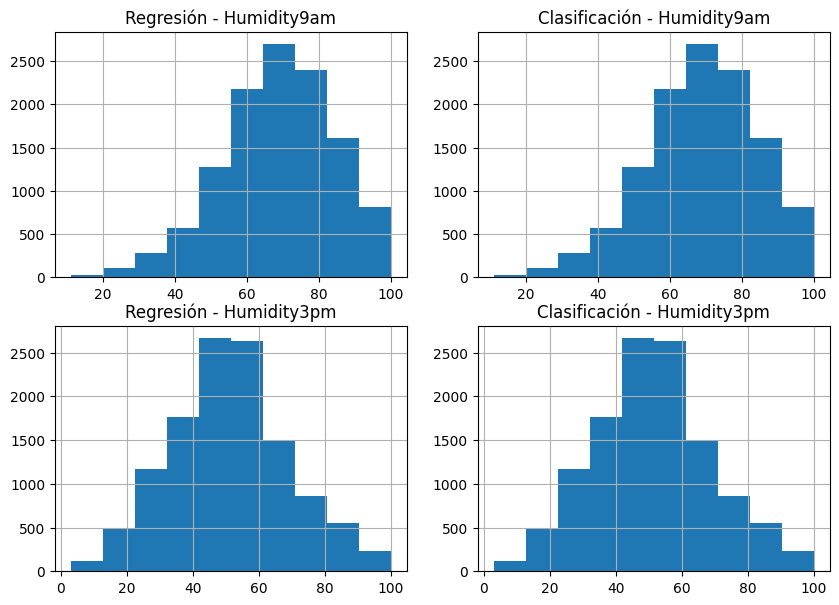

In [40]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Humidity9am'].hist()
plt.title('Regresión - Humidity9am')
plt.subplot(222)
df_clas['Humidity9am'].hist()
plt.title('Clasificación - Humidity9am')
plt.subplot(223)
df_reg['Humidity3pm'].hist()
plt.title('Regresión - Humidity3pm')
plt.subplot(224)
df_clas['Humidity3pm'].hist()
plt.title('Clasificación - Humidity3pm')

In [41]:
df_reg['Humidity9am'].fillna(df_reg['Humidity9am'].mean(),inplace=True)
df_clas['Humidity9am'].fillna(df_reg['Humidity9am'].mean(),inplace=True)

In [42]:
df_clas.Humidity3pm.describe()

count    11988.000000
mean        51.199867
std         17.772806
min          3.000000
25%         39.000000
50%         51.000000
75%         62.000000
max        100.000000
Name: Humidity3pm, dtype: float64

In [43]:
df_clas['Humidity3pm'].fillna(df_clas['Humidity3pm'].mean(), inplace=True)
df_reg['Humidity3pm'].fillna(df_reg['Humidity3pm'].mean(), inplace=True)

## Pressure

Los valores `nan` de esta variables los vamos a llenar con la media. 

Text(0.5, 1.0, 'Clasificación - Pressure3pm')

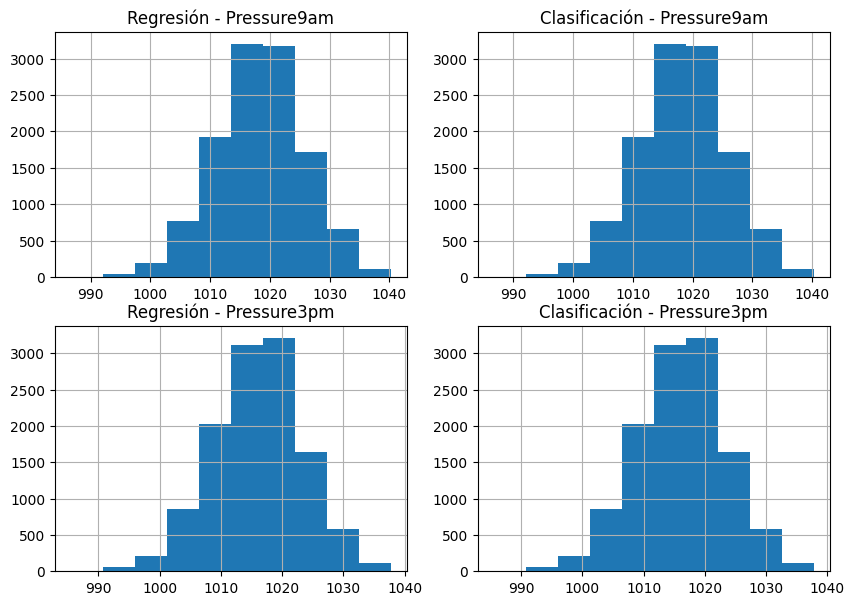

In [44]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Pressure9am'].hist()
plt.title('Regresión - Pressure9am')
plt.subplot(222)
df_clas['Pressure9am'].hist()
plt.title('Clasificación - Pressure9am')
plt.subplot(223)
df_reg['Pressure3pm'].hist()
plt.title('Regresión - Pressure3pm')
plt.subplot(224)
df_clas['Pressure3pm'].hist()
plt.title('Clasificación - Pressure3pm')

In [45]:
df_clas['Pressure3pm'].describe()

count    11823.000000
mean      1016.055453
std          7.277343
min        985.500000
25%       1011.200000
50%       1016.300000
75%       1021.000000
max       1037.800000
Name: Pressure3pm, dtype: float64

In [46]:
df_clas['Pressure9am'].describe()

count    11815.000000
mean      1018.325713
std          7.398393
min        986.700000
25%       1013.500000
50%       1018.500000
75%       1023.300000
max       1040.300000
Name: Pressure9am, dtype: float64

In [47]:
df_reg['Pressure9am'].describe()

count    11815.000000
mean      1018.325713
std          7.398393
min        986.700000
25%       1013.500000
50%       1018.500000
75%       1023.300000
max       1040.300000
Name: Pressure9am, dtype: float64

In [48]:
df_reg['Pressure9am'].fillna(df_reg['Pressure9am'].mean(), inplace=True)
df_reg['Pressure3pm'].fillna(df_reg['Pressure3pm'].mean(), inplace=True)

df_clas['Pressure9am'].fillna(df_clas['Pressure9am'].mean(), inplace=True)
df_clas['Pressure3pm'].fillna(df_clas['Pressure3pm'].mean(), inplace=True)

## Cloud 

Los valores `nan` de esta variable los vamos a llenar con la mediana, ya que en este caso la mediana es mas robusta que el promedio por la distribucion del la variable.

Text(0.5, 1.0, 'Clasificación - Cloud3pm')

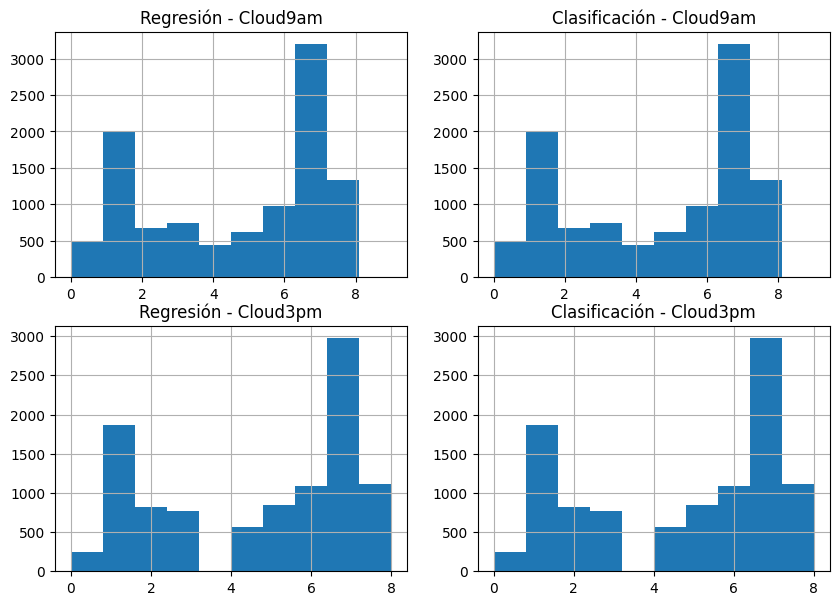

In [49]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Cloud9am'].hist()
plt.title('Regresión - Cloud9am')
plt.subplot(222)
df_clas['Cloud9am'].hist()
plt.title('Clasificación - Cloud9am')
plt.subplot(223)
df_reg['Cloud3pm'].hist()
plt.title('Regresión - Cloud3pm')
plt.subplot(224)
df_clas['Cloud3pm'].hist()
plt.title('Clasificación - Cloud3pm')

In [50]:
df_clas['Cloud3pm'].describe()

count    10287.000000
mean         4.718382
std          2.594606
min          0.000000
25%          2.000000
50%          6.000000
75%          7.000000
max          8.000000
Name: Cloud3pm, dtype: float64

In [51]:
df_clas['Cloud9am'].describe()

count    10482.000000
mean         4.721618
std          2.734851
min          0.000000
25%          2.000000
50%          6.000000
75%          7.000000
max          9.000000
Name: Cloud9am, dtype: float64

In [52]:
df_clas['Cloud3pm'].fillna(df_clas['Cloud3pm'].median(), inplace=True)
df_clas['Cloud9am'].fillna(df_clas['Cloud9am'].median(), inplace=True)

df_reg['Cloud3pm'].fillna(df_reg['Cloud3pm'].median(), inplace=True)
df_reg['Cloud9am'].fillna(df_reg['Cloud9am'].median(), inplace=True)

## Temp 

Las variables de temperatura de la mañana y tarde seran completadas con el promedio, ya que la distribucion es asimetrica, ademas la media y la media se encuentran muy proximas

Text(0.5, 1.0, 'Clasificación - Temp3pm')

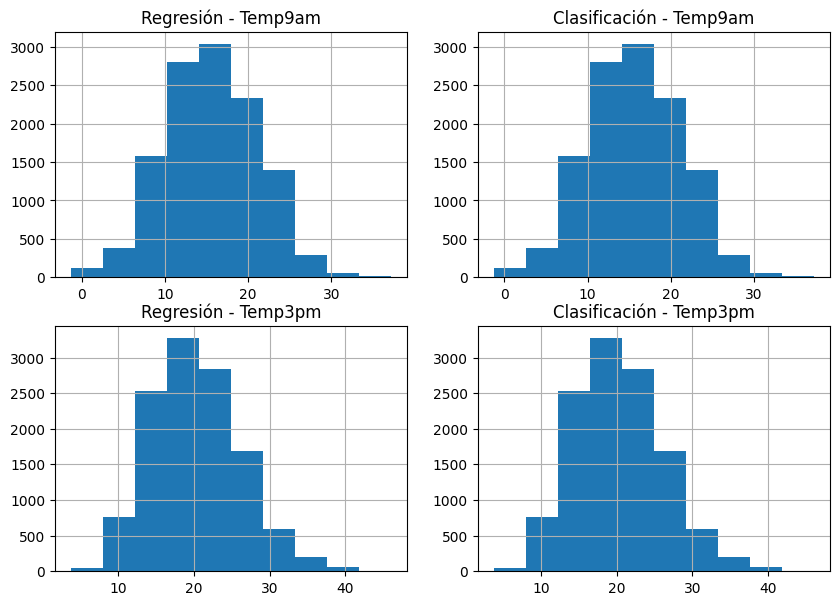

In [53]:
plt.figure(figsize=(10, 7))

plt.subplot(221)
df_reg['Temp9am'].hist()
plt.title('Regresión - Temp9am')
plt.subplot(222)
df_clas['Temp9am'].hist()
plt.title('Clasificación - Temp9am')
plt.subplot(223)
df_reg['Temp3pm'].hist()
plt.title('Regresión - Temp3pm')
plt.subplot(224)
df_clas['Temp3pm'].hist()
plt.title('Clasificación - Temp3pm')

In [54]:
df_reg['Temp3pm'].mean(), df_reg['Temp3pm'].median() 

(20.28962876643915, 19.9)

In [55]:
df_reg['Temp9am'].mean(), df_reg['Temp9am'].median() 

(15.590394539703679, 15.4)

In [56]:
df_reg['Temp9am'].fillna(df_reg['Temp9am'].mean(), inplace=True)
df_reg['Temp3pm'].fillna(df_reg['Temp3pm'].mean(), inplace=True)

df_clas['Temp9am'].fillna(df_clas['Temp9am'].mean(), inplace=True)
df_clas['Temp3pm'].fillna(df_clas['Temp3pm'].mean(), inplace=True)

In [57]:
df_reg.isna().sum()

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainfallTomorrow    0
Month               0
Estacion            0
dtype: int64

In [58]:
df_clas.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
Month            0
Estacion         0
dtype: int64

# Codificación de variables categóricas

In [59]:
for dataframe in df_modelos:
    dataframe['RainToday'].replace(
                    {'Yes': 1, 'No': 0},
                    inplace=True)

La variable `RainTomorrow` solo la usamos en el dataset de clasificación, es otro cambio que relizamos porque en los notebook anteriores la habíamos usado en el modelo de regresión lineal y esto nos estaría provocando una fuga de datos.

In [60]:
df_clas['RainTomorrow'].replace({'Yes': 1, 'No': 0}, inplace=True)
y_test_clas.replace({'Yes': 1, 'No': 0}, inplace=True)

Eliminamos columnas que no vamos a usar

In [61]:
categoricas = ['Location', 'Month', 'Estacion', 'Date']

for dataframe in df_modelos:
    dataframe.drop(columns=categoricas, inplace=True)

En un primer momento hicimos dummies con las variables del viento, pero esto resultó muy complicado trasladarlo al front end, por eso en la versión final mapeamos cada punto cardinal a un número.

In [62]:
# df_reg  = pd.get_dummies(df_reg)
# df_clas = pd.get_dummies(df_clas)

# x_test_reg  = pd.get_dummies(x_test_reg)
# x_test_clas = pd.get_dummies(x_test_reg)

## Imputación en datasets de prueba

Vamos a imputar los datos faltantes en los conjuntos de prueba con el promedio de esa columna en los el conjunto de entrenamiento que ya está imputado.

In [63]:
columnas_numericas = ['MinTemp', 'MaxTemp', 'Rainfall', 
                      'Evaporation', 'Sunshine', 'WindGustSpeed',
                      'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                      'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                      'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

columnas_media = ['Evaporation', 'WindSpeed9am', 
                  'WindSpeed3pm', 'Humidity9am',
                  'Humidity3pm', 'Pressure9am',
                  'Pressure3pm', 'Temp9am', 'Temp3pm']

columnas_mediana = ['Sunshine', 'WindGustSpeed',
                    'Cloud9am', 'Cloud3pm']


promedios_reg  = df_reg[columnas_media].mean()
promedios_clas = df_clas[columnas_media].mean()

x_test_reg[columnas_media] = x_test_reg[columnas_media].fillna(promedios_reg)
x_test_clas[columnas_media] = x_test_clas[columnas_media].fillna(promedios_clas)

mediana_reg = df_reg[columnas_mediana].median()
mediana_clas = df_clas[columnas_mediana].median()

x_test_reg[columnas_mediana] = x_test_reg[columnas_mediana].fillna(mediana_reg)
x_test_clas[columnas_mediana] = x_test_clas[columnas_mediana].fillna(mediana_clas)

# Normalización

Normalizamos los datasets para el entrenamiento de la regresión y la clasificación, estamos normalizando las variables explicativas y objetivo a la vez.

In [64]:
scaler = StandardScaler()

cols_reg = columnas_numericas + ['RainfallTomorrow']

# Guardamos una copia de un dataset originales 
# sin normalizar para el frontend con streamlit
df_reg_desnorm = df_reg.copy()

# Normalizamos los datasets para entrenar los modelos
df_reg[cols_reg] = scaler.fit_transform(df_reg[cols_reg])
df_clas[columnas_numericas] = scaler.fit_transform(df_clas[columnas_numericas])

Normalizamos los datasets de prueba para la regresión y clasificación.

In [65]:
x_test_reg[columnas_numericas] = scaler.fit_transform(x_test_reg[columnas_numericas])
y_test_reg = scaler.fit_transform(pd.DataFrame(y_test_reg))

x_test_clas[columnas_numericas] = scaler.fit_transform(x_test_clas[columnas_numericas])

### Matriz de correlación 

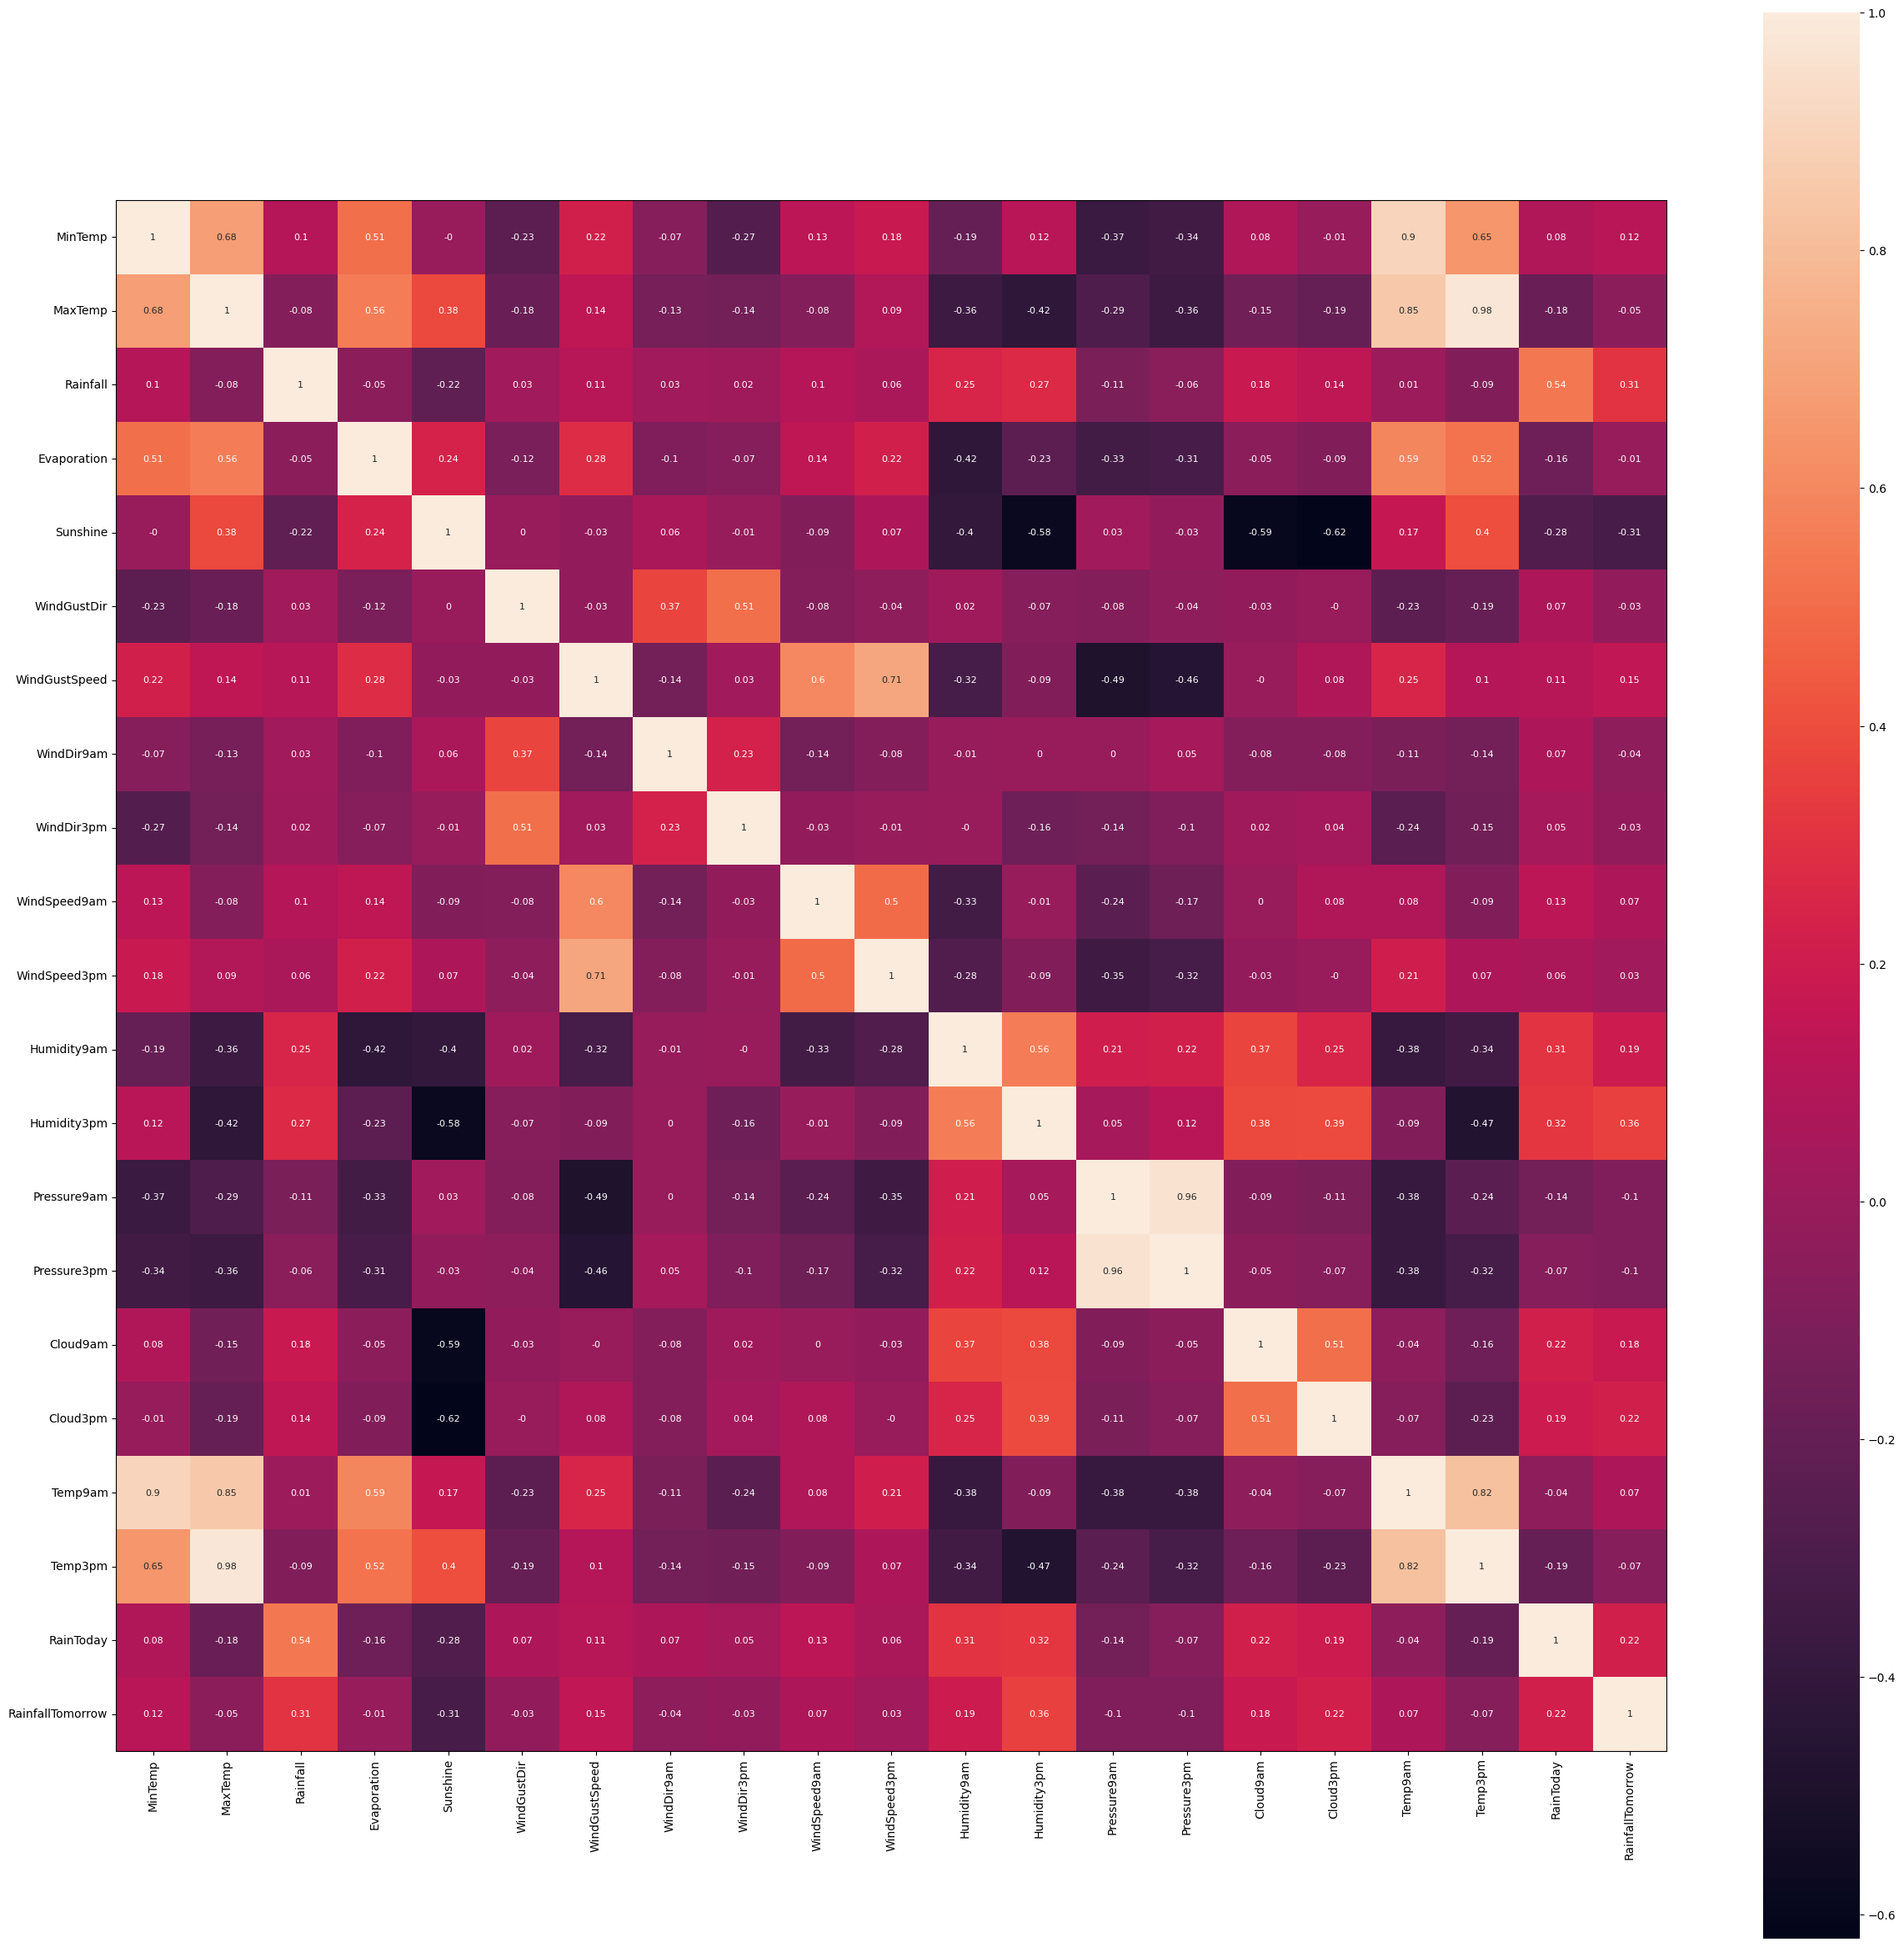

In [66]:
plt.figure(figsize=(30, 30))

heatmap = sns.heatmap(
    df_reg.corr().round(2),
    annot=True,
    square=True,
    annot_kws={'size': 8},  
)

for _, spine in heatmap.spines.items():
    spine.set_visible(True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

plt.show()

En la matriz de correlación podemos qué variables tiene más correlación con la variables objetivos, nos da información sobre relaciones positivas o negativas y el fuerza de cada relación lineal. Consideramos que no debemos eliminar ninguna variable para el entrenamiento de los modelos.

También observamos que solo hay un par de relaciones que parecen ser fuertemente lineales en este dataset, las cuales son `MaxTemp` con `Temp3pm`, esto tiene sentido porque durante el mediodía y la tarde se llegaran a los picos de temperatura de los días. Con `MinTemp` y `Temp9am` ocurre algo similar como es de esperar.

# Scatter plot entre `RainfallTomorrow` y el resto de variables

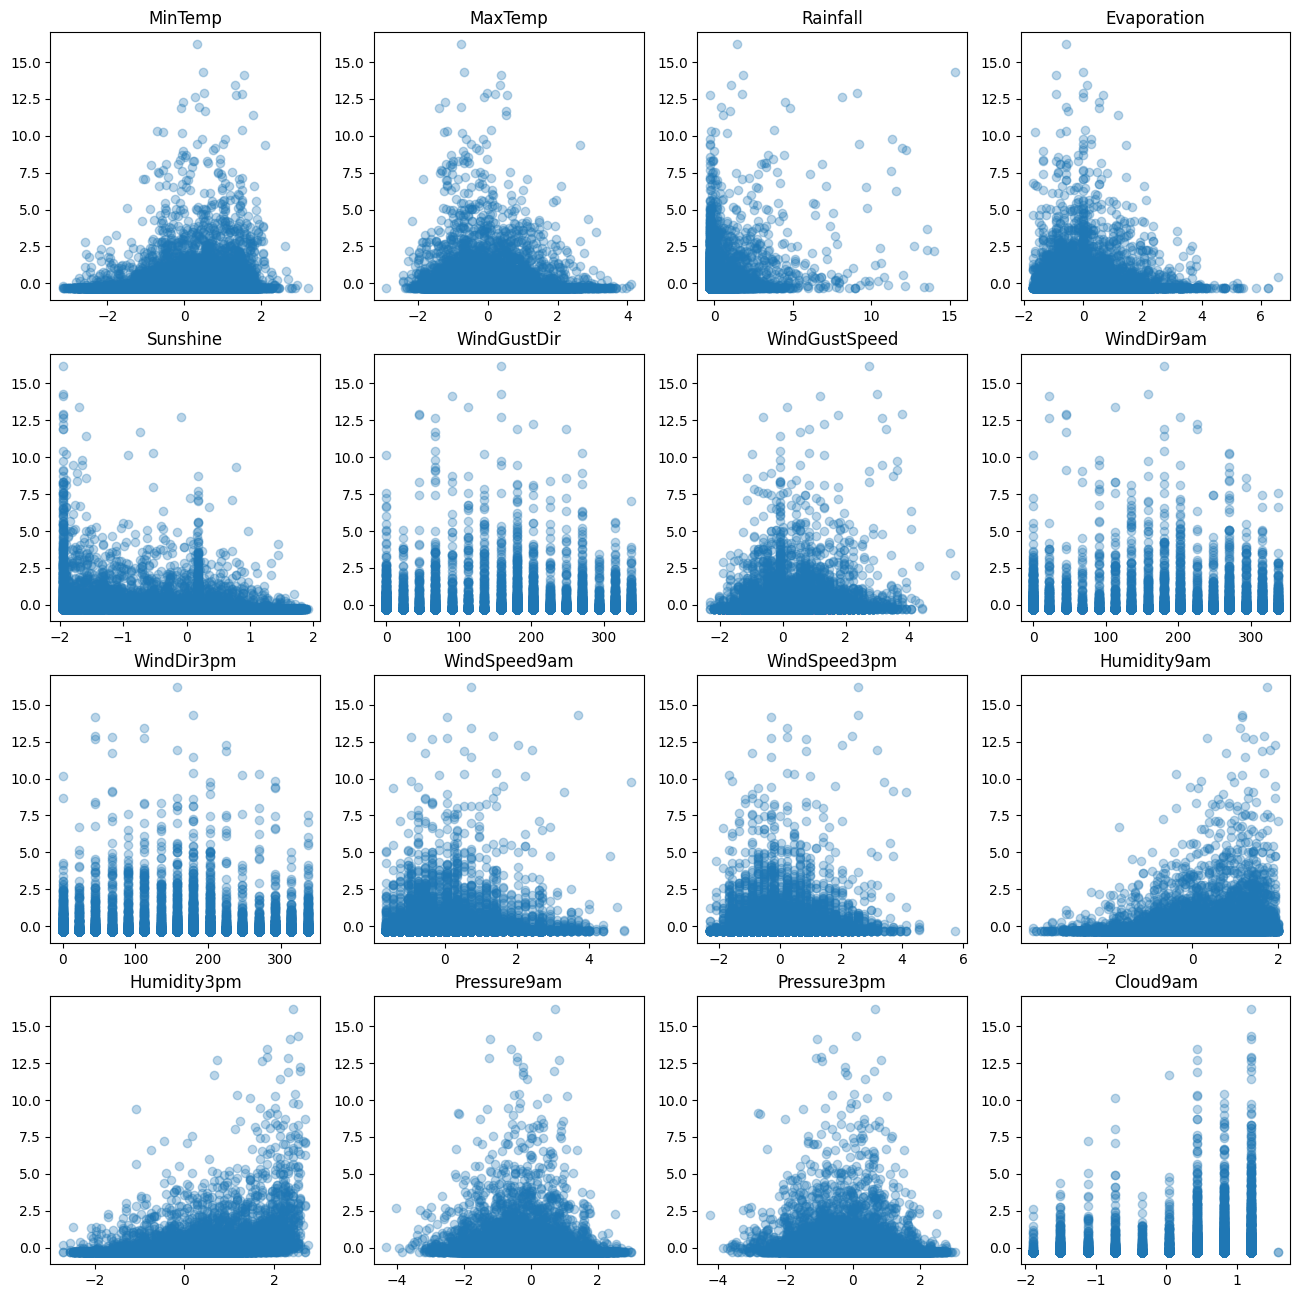

In [67]:
plt.figure(figsize=(16, 16))

for idx, col in enumerate(df_reg.columns[:16], start=1):  
    plt.subplot(4, 4, idx)
    plt.scatter(data=df_reg, x=col, y='RainfallTomorrow', alpha=.3)
    plt.title(col)

De estos gráficos podemos concluir que las variables no tienen una relación lineal con la variable objetivo.

# Dataframes para el entrenamiento

In [68]:
x_train_regre = df_reg.drop(columns=['RainfallTomorrow'])
y_train_regre = df_reg['RainfallTomorrow']  

x_train_clasi = df_clas.drop(columns=['RainTomorrow'])
y_train_clasi = df_clas['RainTomorrow']

# Balanceo del dataset

Con SMOTE balanceamos las clases en el dataset de entrenamiento para la clasificación, esto es necesario para que el modelo no aprenda con datos sesgados hacia una clase. Decidimos balancear con SMOTE porque consideramos que es mejor aumentar el número de clase minoritaria a través de datos sintéticos que repetir los datos que ya tenemos.

In [69]:
smote = SMOTE(random_state=42)

x_SMOTE, y_SMOTE = smote.fit_resample(x_train_clasi, y_train_clasi)

Graficamos la comparación entre las clases antes y después

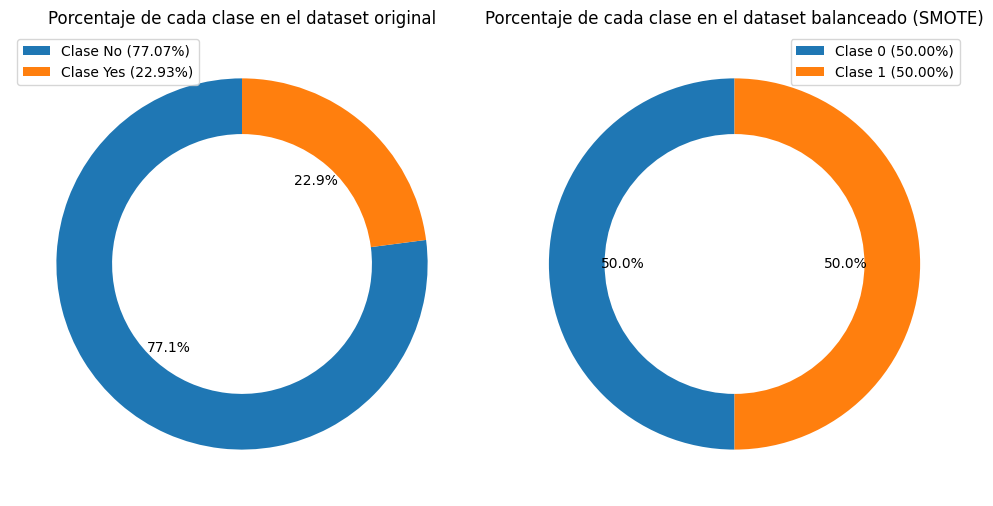

In [70]:
# Dataset sin balancear
unique, counts = np.unique(y_train_clas, return_counts=True)
porcentajes = (counts / len(y_train_clas)) * 100

plt.figure(figsize=(10, 5))

# Subplot para el primer gráfico
plt.subplot(1, 2, 1) 
labels = [f'Clase {clase} ({porcentaje:.2f}%)' for clase, porcentaje in zip(unique, porcentajes)]
plt.pie(counts, labels=None, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))
plt.gca().add_artist(plt.Circle((0, 0), 0.2, fc='white'))
plt.title('Porcentaje de cada clase en el dataset original')
plt.legend(labels)

# Dataset balanceado con SMOTE
unique_smote, counts_smote = np.unique(y_SMOTE, return_counts=True)
porcentajes_smote = (counts_smote / len(y_SMOTE)) * 100

# Subplot para el segundo gráfico
plt.subplot(1, 2, 2) 
labels_smote = [f'Clase {clase} ({porcentaje:.2f}%)' for clase, porcentaje in zip(unique_smote, porcentajes_smote)]
plt.pie(counts_smote, labels=None, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))
plt.gca().add_artist(plt.Circle((0, 0), 0.2, fc='white'))
plt.title('Porcentaje de cada clase en el dataset balanceado (SMOTE)')
plt.legend(labels_smote)

plt.tight_layout()
plt.show()

# Regresión Lineal

In [71]:
def metricas(y_test, y_pred):
    print('R2:   %.2f' % r2_score(y_test, y_pred))
    print('MSE:  %.2f' % mean_squared_error(y_test, y_pred))
    print('RMSE: %.2f' % sqrt(mean_squared_error(y_test, y_pred)))
    print('MAE:  %.2f' % mean_absolute_error(y_test, y_pred))
    print('MAPE: %.2f' % mean_absolute_percentage_error(y_test, y_pred))

In [72]:
reg = LinearRegression()
reg.fit(x_train_regre, y_train_regre)

LinearRegression()

In [73]:
y_pred_reg = reg.predict(x_test_reg)

metricas(y_test_reg, y_pred_reg)

R2:   0.19
MSE:  0.81
RMSE: 0.90
MAE:  0.42
MAPE: 1.71


Probamos un modelo con menos variables

In [74]:
modelo2_features = ['MinTemp', 'MaxTemp',
                    'Rainfall', 'Sunshine',
                    'WindGustSpeed', 'Humidity3pm', 
                    'RainToday']

reg2 = LinearRegression()
reg2.fit(x_train_regre[modelo2_features], y_train_regre)

LinearRegression()

In [75]:
y_pred2 = reg2.predict(x_test_reg[modelo2_features])

metricas(y_test_reg, y_pred2)

R2:   0.17
MSE:  0.83
RMSE: 0.91
MAE:  0.43
MAPE: 1.68


Vemos que con menos variables explicativas el modelo no mejora, por lo tanto decidimos usar todas las variables del dataset para el resto de los modelos.

## Lasso

In [76]:
las = LassoCV()
las.fit(x_train_regre, y_train_regre)

LassoCV()

In [77]:
y_pred_L = las.predict(x_test_reg)

metricas(y_test_reg, y_pred_L)

R2:   0.19
MSE:  0.81
RMSE: 0.90
MAE:  0.42
MAPE: 1.66


## Ridge

In [78]:
rid = RidgeCV()
rid.fit(x_train_regre, y_train_regre)

RidgeCV()

In [79]:
y_pred_R = rid.predict(x_test_reg)

metricas(y_test_reg, y_pred_R)

R2:   0.19
MSE:  0.81
RMSE: 0.90
MAE:  0.42
MAPE: 1.71


## ElasticNet

In [80]:
en = ElasticNetCV()
en.fit(x_train_regre, y_train_regre)

ElasticNetCV()

In [81]:
y_pred_e = en.predict(x_test_reg)

metricas(y_test_reg, y_pred_e)

R2:   0.19
MSE:  0.81
RMSE: 0.90
MAE:  0.42
MAPE: 1.65


De los cuatro modelos lineales que probamos vemos que todos mantienen un $R^2$ de aproximadamente $0.19$, es decir que solo pueden llegar a explicar un $19\%$ de la variabilidad de los datos. Sin embargo todas las métricas de error son bastantes bajas, por lo que podemos considerar que el rendimiento de estos modelos es moderado, aunque podríamos llegar a mejorar estás métricas con otros tipos de modelos.

# Regresión logística

In [82]:
logistica = LogisticRegression()

logistica.fit(x_train_clasi, y_train_clasi)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      2323
           1       0.70      0.49      0.58       685

    accuracy                           0.84      3008
   macro avg       0.78      0.72      0.74      3008
weighted avg       0.83      0.84      0.83      3008



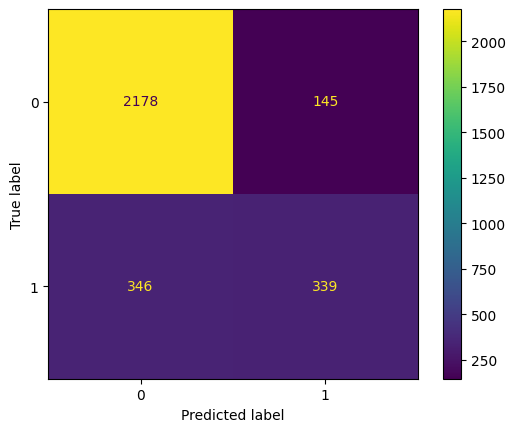

In [83]:
y_pred_log = logistica.predict(x_test_clas)

print(classification_report(y_test_clas, y_pred_log))
ConfusionMatrixDisplay(confusion_matrix(y_test_clas, y_pred_log)).plot()

Vemos que en promedio el modelo tiene buenas métricas de precisión para ambas clases, sin embargo las métricas de `recall` y `f1-score` para la clase minoritaría son más bajas, además en la matriz de confusión vemos que para la clase 1 solo se detectaron 339 verdaderos positivos.

Ahora vamos a probar con el dataset balanceado para ver si estas métricas mejoran.

In [84]:
logistica_bal = LogisticRegression()

logistica_bal.fit(x_SMOTE, y_SMOTE)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      2323
           1       0.50      0.75      0.60       685

    accuracy                           0.77      3008
   macro avg       0.71      0.77      0.72      3008
weighted avg       0.82      0.77      0.79      3008



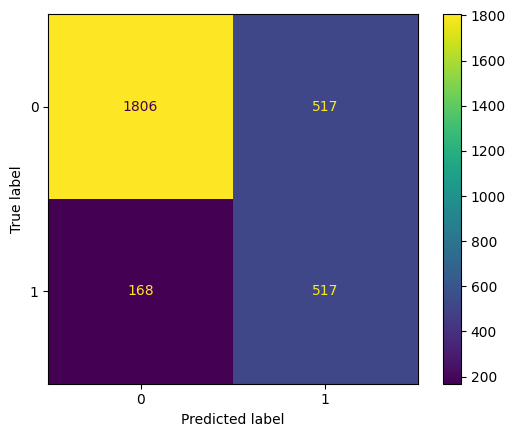

In [85]:
y_pred_smo = logistica_bal.predict(x_test_clas)

print(classification_report(y_test_clas, y_pred_smo))
ConfusionMatrixDisplay(confusion_matrix(y_test_clas, y_pred_smo)).plot()

Notamos que con las clases balanceadas el modelo mejora la precisión general de los verdaderos positivos, sin embargo baja a la mitad la precisión para predecir que sí va a llover y la cantidad de falsos positivos incrementó. Pero también mejoran las métricas para la clase minoritaría a diferencia del modelo anterior.

Concluimos que la elección de uno de estos dos modelos dependerá del contexto del problema y si nos preocupa más predecir con alta exactitud cuando no va a llover y tener peores predicciones para el resto de los casos o si preferimos tener un modelo más equilibrado a costo de tener más falsos positivos en ambas clases.

## Curva Roc del modelo con mejor precision.

In [86]:
# Obtengo las probabilidades de predicción del modelo
y_probs = logistica_bal.predict_proba(x_test_clas)[:,1]

# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test_clas, y_probs)
roc_auc = auc(fpr, tpr)

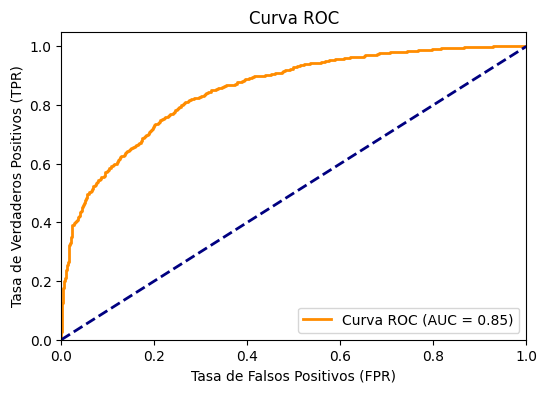

In [87]:
# Grafico la curva ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

El área bajo la curva es cercano a $1$, por lo que este modelo con las clases balanceadas tiene un buen rendimiento para la clasificación binaria.

# Modelo base

## Modelo base de regresión lineal

Nuestro modelo base para la regresión usará soloamente dos variables para hacer la predicción. Vamos a suponer que con la variable `RainToday` y `MinTemp` del día lograremos predecir cuánto lloverá mañana.

In [88]:
X = df_reg[['MinTemp', 'RainToday']]
Y = df_reg['RainfallTomorrow']

# Dividir los datos en conjunto de entrenamiento y de prueba
X_train_Base, X_test_Base, Y_train_Base, Y_test_Base = train_test_split(X, Y, test_size=0.20, random_state=42)

In [89]:
M_base = LinearRegression()

M_base.fit(X_train_Base, Y_train_Base)

LinearRegression()

In [90]:
y_pred = M_base.predict(X_test_Base)

metricas(Y_test_Base, y_pred)

R2:   0.06
MSE:  0.96
RMSE: 0.98
MAE:  0.44
MAPE: 1.54


Podemos ver claramente que el modelo base es superado por cualquier modelo de regresión lineal que hicimos anteriormente usando todas las variables.

## Modelo base de clasificación

Para nuestro modelo base de clasificaión vamos a hacer una regresión logística muy simple para predecir si llueve o no mañana, solamente vamos a usar una variable para entrenarla.

In [91]:
X_Base = df_clas[['RainToday']]
Y_Base = df_clas['RainTomorrow']

X_entreno_b, X_testeo_b, Y_entreno_b, Y_testeo_b = train_test_split(X_Base, Y_Base, test_size=0.20, random_state=42)

In [92]:
logistic_model_Base = LogisticRegression(random_state=42)
logistic_model_Base.fit(X_entreno_b, Y_entreno_b)

LogisticRegression(random_state=42)

Resultados con regresión logística

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      1854
           1       0.00      0.00      0.00       552

    accuracy                           0.77      2406
   macro avg       0.39      0.50      0.44      2406
weighted avg       0.59      0.77      0.67      2406



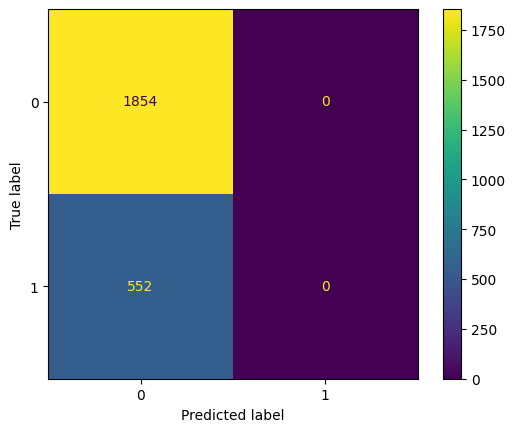

In [93]:
y_pred_b = logistic_model_Base.predict(X_testeo_b)

print("Resultados con regresión logística\n")
print(classification_report(Y_testeo_b, y_pred_b))
ConfusionMatrixDisplay(confusion_matrix(Y_testeo_b, y_pred_b)).plot()

Nuevamente vemos que el modelo base es superado por los dos modelos que realizamos anteriormente. En la matriz de confusión observamos que este modelo ingenuo clasificó con una alta precisión la clase de 'No', sin embargo la precisión para la clase 'Sí' es nula ya que no logró clasificar correctamente ninguna observación de esta clase.

# Redes neuronales

## Modelo de redes neuronales para regresión

In [94]:
def objective_reg(trial):
    # Crear el modelo
    model = Sequential()

    # Definir hiperparámetros a optimizar
    num_layers = trial.suggest_int('num_layers', 1, 5)
    model.add(Dense(10, activation='relu', input_shape=(x_train_regre.shape[1],)))

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128)
        model.add(Dense(num_units, activation='relu'))

    model.add(Dense(1))  # Capa de salida para regresión lineal

    # Compilar el modelo
    model.compile(optimizer='adam', loss='mean_squared_error')

    X_train, X_valid, y_train, y_valid = train_test_split(x_train_regre, y_train_regre, test_size=0.2, random_state=42)

    # Entrenar el modelo
    model.fit(x_train_regre, y_train_regre, validation_data=(X_valid, y_valid), epochs=10, batch_size=64, verbose=0)

    # Evaluar el modelo
    score = model.evaluate(X_valid, y_valid, verbose=0)
    return score


'''
study = optuna.create_study(direction='minimize')  # Estamos minimizando la pérdida
study.optimize(objective_reg, n_trials=100)

best_params = study.best_params
print("Best parameters:", best_params)
'''

'\nstudy = optuna.create_study(direction=\'minimize\')  # Estamos minimizando la pérdida\nstudy.optimize(objective_reg, n_trials=100)\n\nbest_params = study.best_params\nprint("Best parameters:", best_params)\n'

In [95]:
model_reg = Sequential([
        Dense(124, activation='relu', input_shape=(x_train_regre.shape[1],)),
        Dropout(0.05),
        Dense(120, activation='relu'),
        Dropout(0.05),
        Dense(60, activation='relu'),
        Dropout(0.05),
        Dense(24, activation='relu'),
        Dropout(0.05),
        Dense(1, activation='linear')
])

model_reg.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_squared_error'])

In [96]:
if os.path.exists('models/regresion.h5'):
    # Cargamos el modelo existente
    model_reg = load_model('models/regresion.h5')
    history_reg = np.load('models/regresion_history.npy', allow_pickle='TRUE').item()
else:
    # Entrenamos y guardamos el modelo
    history_reg = model_reg.fit(x_train_regre,
                                y_train_regre,
                                epochs=1000,
                                batch_size=64,
                                validation_split=0.2,
                                verbose=1)

    model_reg.save('models/regresion.h5')
    np.save('models/regresion_history.npy', history_reg.history)

In [97]:
# Evaluar el modelo en los datos de entrenamiento y validación
train_scores = model_reg.evaluate(x_train_regre, y_train_regre, verbose=0)
valid_scores = model_reg.evaluate(x_test_reg, y_test_reg, verbose=0)

# Calcular R^2 y MSE para los conjuntos de entrenamiento y validación
train_r2 = r2_score(y_train_regre, model_reg.predict(x_train_regre))
valid_r2 = r2_score(y_test_reg, model_reg.predict(x_test_reg))

train_mse = mean_squared_error(y_train_regre, model_reg.predict(x_train_regre))
valid_mse = mean_squared_error(y_test_reg, model_reg.predict(x_test_reg))

# Imprimir los resultados
print(f'Train R^2: {train_r2:.4f}, Train MSE: {train_mse:.4f}')
print(f'Test R^2: {valid_r2:.4f}, Test MSE: {valid_mse:.4f}')

319/376 [========================>.....] - ETA: 0s

94/94 [==============================] - 0s 419us/step
Train R^2: 0.5445, Train MSE: 0.4555
Test R^2: 0.2427, Test MSE: 0.7573


Vemos que la red neuronal muestra una mejora respecto al las regresiones lineales, aunque esta mejora de aproximadamente un $5\%$ no es muy alta. Nuevamente deberíamos preguntarnos para el contexto de este problema si vale la pena aumentar la complejidad del modelo para aumentar tan poco la explicabilidad de los datos.

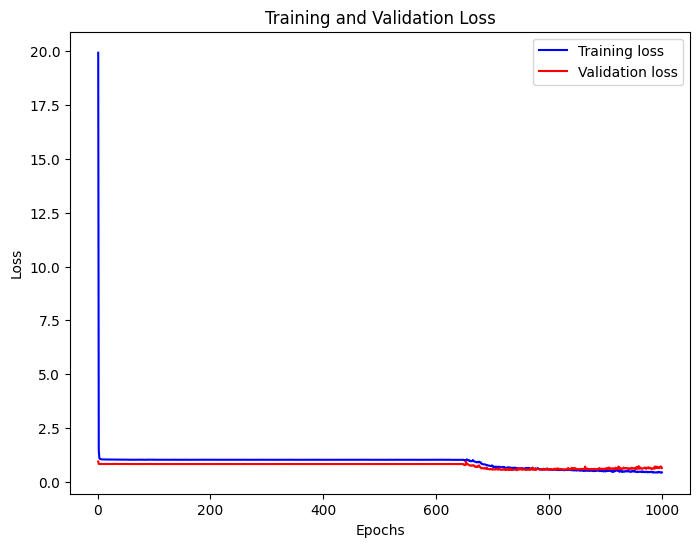

In [98]:
# Extraer la información del historial
train_loss = history_reg['loss']
val_loss = history_reg['val_loss']
# train_loss = history_reg.history['loss']
# val_loss = history_reg.history['val_loss']

# Crear el gráfico
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(8, 6))

# Plotear el loss del entrenamiento y validación
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mostrar el gráfico
plt.show()

Como el *trainig loss* baja a mayor cantidad de épocas, podemos decir que este modelo no está presenta *underfitting*, ya que el modelo se llega a ajustar correctamente a los datos del entrenamiento. También vemos que la curva de *validation loss* comienza baja y sigue bajando a medida que avanza el tiempo, esto nos puede dar un indicio de que el modelo está generalizando correctamente los datos que nunca vio.

## Modelo redes neuronales para clasificación

In [99]:
def objective_clas(trial):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    model = Sequential()

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128)
        model.add(Dense(num_units, activation='relu'))

    model.add(Dense(2, activation='softmax'))  # 2 clases de salida


    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision()])

    # Suponiendo que tienes datos x_SMOTE, y_SMOTE, x_test_clas, y_test_clas
    X_train, X_valid, y_train, y_valid = train_test_split(x_SMOTE, y_SMOTE, test_size=0.2, random_state=42)

    # Convertir etiquetas a one-hot encoding
    label_encoder = LabelEncoder()
    y_train = to_categorical(label_encoder.fit_transform(y_train))
    y_valid = to_categorical(label_encoder.transform(y_valid))

    # Entrenar el modelo
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5, batch_size=32, verbose=0)

    # Evaluar el modelo con datos de validación
    score = model.evaluate(X_valid, y_valid, verbose=0)
    return score[1]  # Devuelve la precisión como la métrica objetivo

'''
# Crear un estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective_clas, n_trials=50)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores parámetros encontrados:", best_params)
'''

'\n# Crear un estudio de Optuna\nstudy = optuna.create_study(direction=\'maximize\')\nstudy.optimize(objective_clas, n_trials=50)\n\n# Obtener los mejores hiperparámetros\nbest_params = study.best_params\nprint("Mejores parámetros encontrados:", best_params)\n'

In [100]:
# Creamos las red neuronal con los parámetros optimizados
model_clas = Sequential()
model_clas.add(Dense(74, input_shape=(x_SMOTE.shape[1],), activation='relu'))
model_clas.add(Dropout(0.5))
model_clas.add(Dense(36, activation='relu'))
model_clas.add(Dense(1, activation='sigmoid'))

# Compilamos el modelo con la métrica de precisión
model_clas.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision()])

In [101]:
if os.path.exists('models/clasificacion.h5'):
    # Cargamos el modelo existente
    model_clas = load_model('models/clasificacion.h5')
    history_clas = np.load('models/clasificacion_history.npy', allow_pickle='TRUE').item()
else:
    # Entrenamos y guardamos el modelo
    history_clas = model_clas.fit(x_SMOTE,
                                 y_SMOTE,
                                 epochs=1000,
                                 batch_size=32,
                                 validation_split=0.2,
                                 verbose=1)

    model_clas.save('models/clasificacion.h5')
    np.save('models/clasificacion_history.npy', history_clas.history)

In [102]:
# Evaluar el modelo
loss, precision = model_clas.evaluate(x_test_clas, y_test_clas)
print(f'Error: {loss}')
print(f'Precisión: {precision}')

94/94 [==============================] - 0s 539us/step - loss: 0.5060 - precision_50: 0.5347
Error: 0.5060314536094666
Precisión: 0.5346851944923401


94/94 [==============================] - 0s 463us/step


Accuracy: 79.39%

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86      2323
           1       0.53      0.73      0.62       685

    accuracy                           0.79      3008
   macro avg       0.72      0.77      0.74      3008
weighted avg       0.83      0.79      0.80      3008



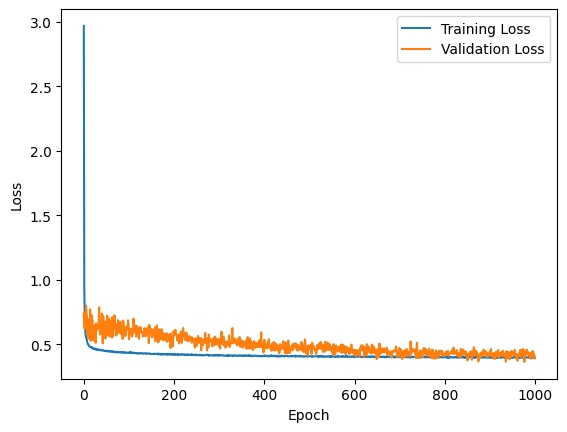

In [103]:
predictions_prob = model_clas.predict(x_test_clas)


predictions = (predictions_prob > 0.5).astype('int32')  # Convertir probabilidades a etiquetas binarias

# Evaluación del modelo en el conjunto de prueba
accuracy = accuracy_score(y_test_clas, predictions)
conf_matrix = confusion_matrix(y_test_clas, predictions)
classification_rep = classification_report(y_test_clas, predictions)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:\n", classification_rep)

# Plotear la pérdida durante el entrenamiento
plt.plot(history_clas['loss'], label='Training Loss')
plt.plot(history_clas['val_loss'], label='Validation Loss')
# plt.plot(history_clas.history['loss'], label='Training Loss')
# plt.plot(history_clas.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

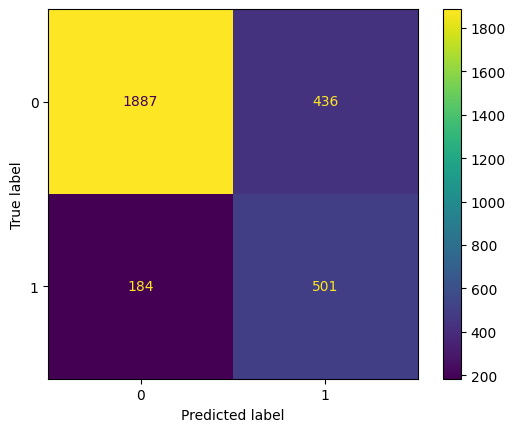

In [104]:
ConfusionMatrixDisplay(conf_matrix).plot()

Observamos con las métricas que las redes neuronales son un poco mejor que la regresión logística para la clasificación de este dataset.

# Optimización

Para la regresión lineal el propio modelo de `ElasticNetCV` se encarga de optimizar los parámetros `alpha` y `l1_ratios`, en el caso de las redes neuronales ya se optimizaron con `optuna` en el apartado anterior, así que solamente vamos a optimizar la regresión logística.

In [105]:
# Parámetros a optimizar
params_clas = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced']
}

opt_clas = RandomizedSearchCV(
            LogisticRegression(random_state=42),
            params_clas)

opt_clas.fit(x_SMOTE, y_SMOTE)

RandomizedSearchCV(estimator=LogisticRegression(random_state=42),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'class_weight': [None, 'balanced'],
                                        'max_iter': [100, 200, 300],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'lbfgs',
                                                   'saga']})

In [106]:
mejor_modelo_clas = opt_clas.best_estimator_

              precision    recall  f1-score   support

           0       0.92      0.79      0.85      2323
           1       0.51      0.75      0.61       685

    accuracy                           0.78      3008
   macro avg       0.71      0.77      0.73      3008
weighted avg       0.82      0.78      0.79      3008



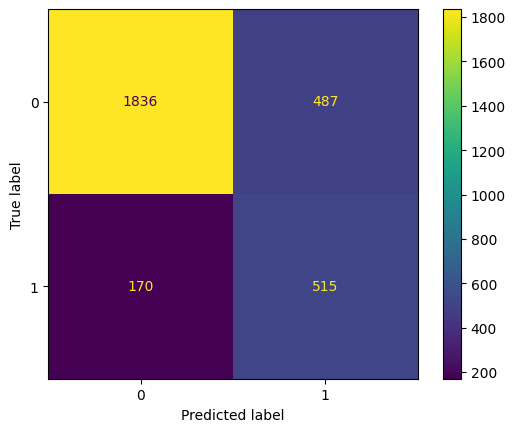

In [107]:
y_pred_clas = mejor_modelo_clas.predict(x_test_clas)

print(classification_report(y_test_clas, y_pred_clas))
ConfusionMatrixDisplay(confusion_matrix(y_test_clas, y_pred_clas)).plot()

Vemos que aunque optimizemos los hiper-parámetros practicamente no hay ninguna diferencia en las métricas del modelo. Por lo que consideramos que para este caso no es justificable el tiempo extra que se demora `RandomizedSearchCV` en optimizar porque los resultados son prácticamente iguales que usar los parámetros por defecto del modelo.

# Explicabilidad

La idea es encontrar una explicación a lo que hizo nuestro modelo, si nuestro modelo encontro que una característica que sea mas importante que otra, etc. 

**SHAP** nos proporciona una forma de entender que variables están impulsando las predicciones del modelo y cómo contribuyen a la predicción. Esto es valioso porque además de conocer que características son las mas importantes para cada modelo, también podemos ver como interactuan y afectan al resultado final de las predicciones.

## Regresión lineal

Para la explicabilidad vamos a usar el modelo de *ElasticNet* ya que es el que mejores métricas dio de los modelos de regresión lineal.

### Explicabilidad global del modelo

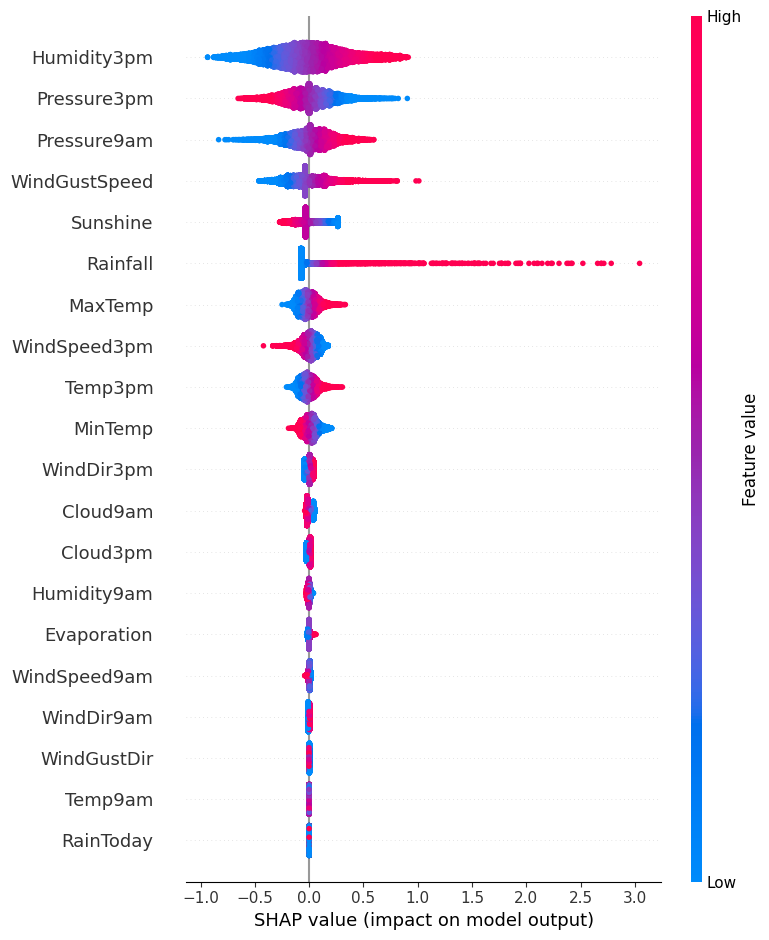

In [108]:
explainer_reg = shap.LinearExplainer(en,
                                 x_train_regre.astype('float64').copy(),
                                 features_names=x_train_regre.columns.copy())

shap_values_reg = explainer_reg(x_train_regre.astype('float64').copy())

shap.summary_plot(shap_values_reg, x_train_regre)

En este gráfico vemos que la variable `Humidity3pm` tiene una correlación positiva con la variable a predecir, lo que resulta lógico ya que entre más humedad haya entre la mañana y la tarde, probablemente más cantidad de lluvia caiga.

Casos que son interesantes de analizar serían el de variables como `Pressure3pm`, `Sunshine`, `WindSpeed3pm` y `MinTemp` ya que entre más grandes son menos cantidad de lluvia predice el modelo.

Las que estásn relaciondas a la presión atmosférica, luz del sol y temperatura pueden llegar a ser relaciones más obvias con la cantidad de lluvia. Sin embargo la dirección del viento total y las de las 3 pm se comportan de manera inversa, creemos que está relación podría llegar a explicarse con más variables relaciondas a la ubicación geográfica de cada ciudad, como por ejemplo la latitud y longitud, que son datos con los que no contamos en el dataset.

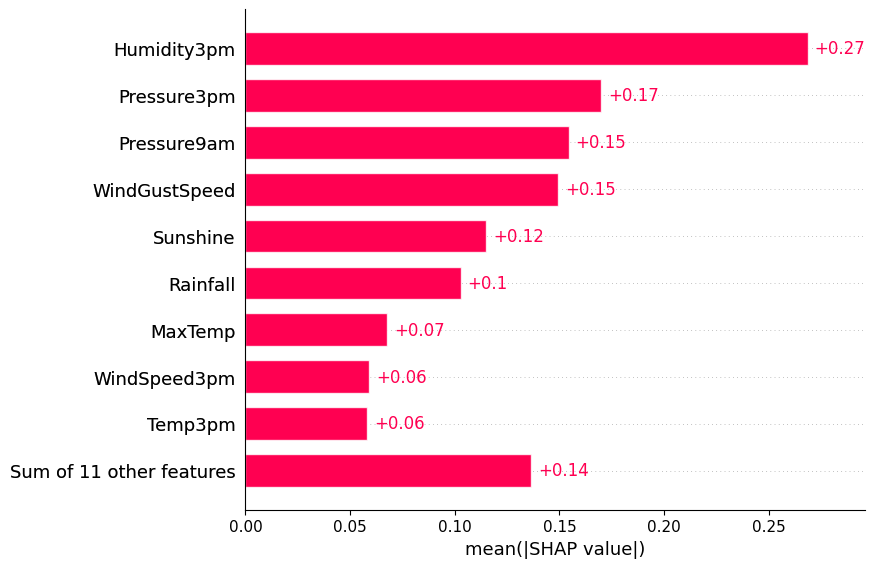

In [109]:
explanation_global_reg = shap.Explanation(
                            shap_values_reg,
                            base_values=explainer_reg.expected_value,
                            feature_names=x_train_regre.columns,
                            data=x_test_reg)

shap.plots.bar(explanation_global_reg)

Esta grafica nos muestra en promedio cuáles son los valores más importantes para la regresión lineal.

Explicabilidad local del modelo

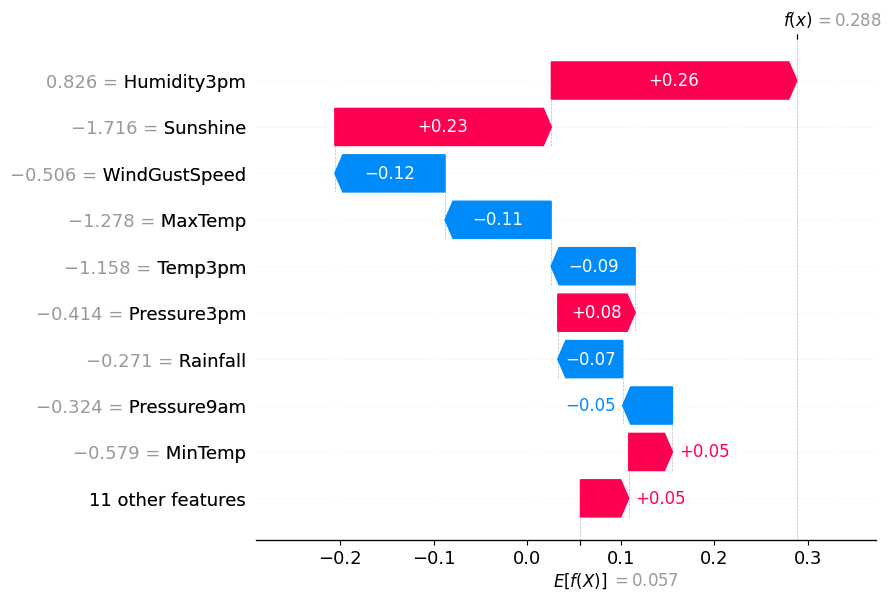

In [110]:
idx = 50

en.predict(x_test_reg)[idx]

shap_values_reg = explainer_reg(x_test_reg)

explanation = shap.Explanation(values=shap_values_reg[idx],
                                base_values=explainer_reg.expected_value,
                                feature_names=x_train_regre.columns)

shap.plots.waterfall(explanation)

## Regresión logística

Explicabilidad global

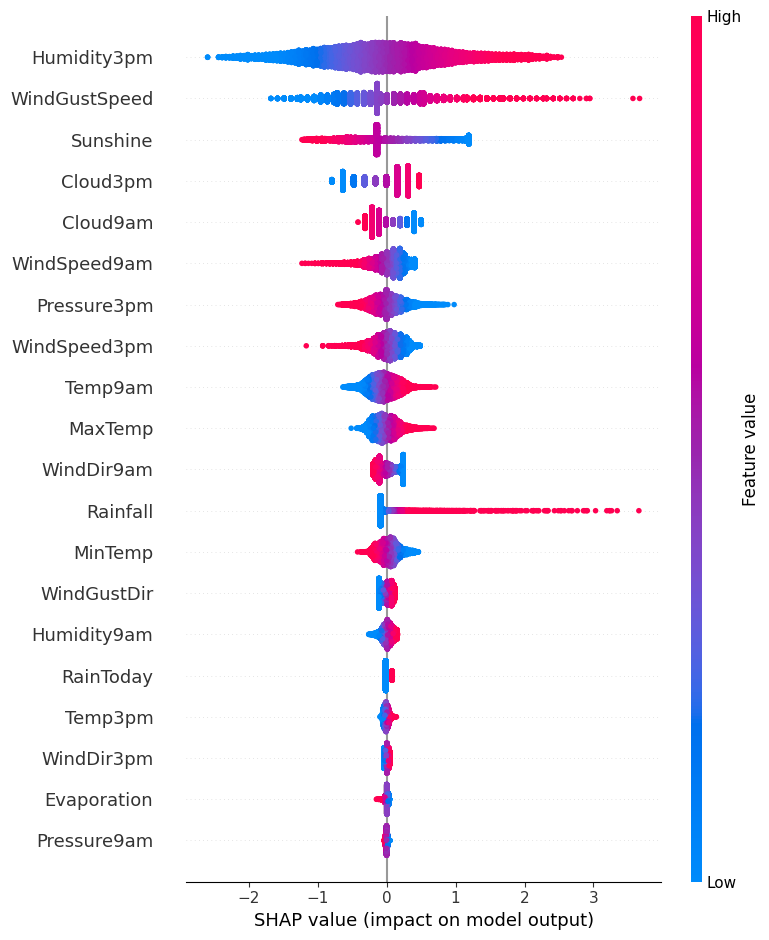

In [111]:
explainer_clas = shap.LinearExplainer(logistica,
                                 x_train_clasi.astype('float64'),
                                 features_names=x_train_clasi.columns)

shap_values_clas = explainer_clas(x_train_clasi.astype('float64'))

shap.summary_plot(shap_values_clas, x_train_clasi)

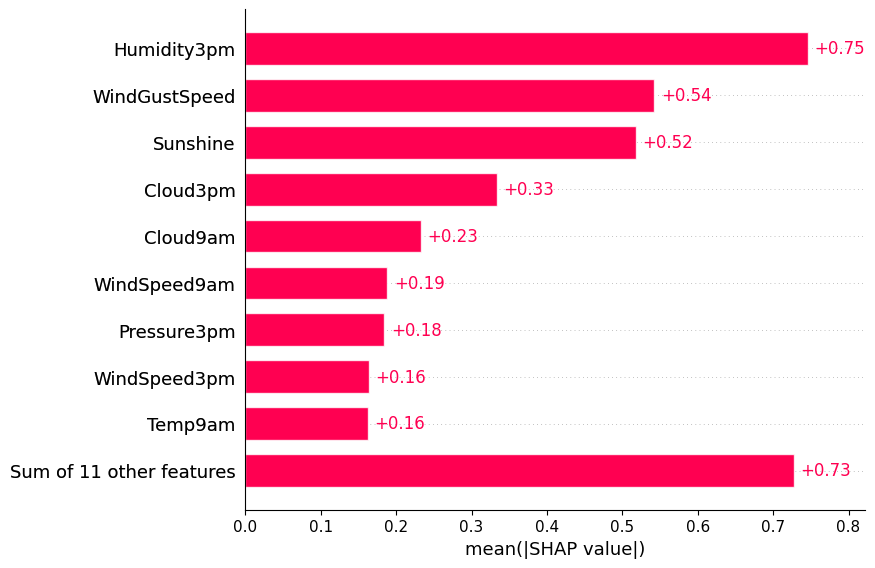

In [112]:
explanation_global_clas = shap.Explanation(
                            shap_values_clas,
                            base_values=explainer_clas.expected_value,
                            feature_names=x_train_clasi.columns,
                            data=x_test_clas)

shap.plots.bar(explanation_global_clas)

Explicabilidad local

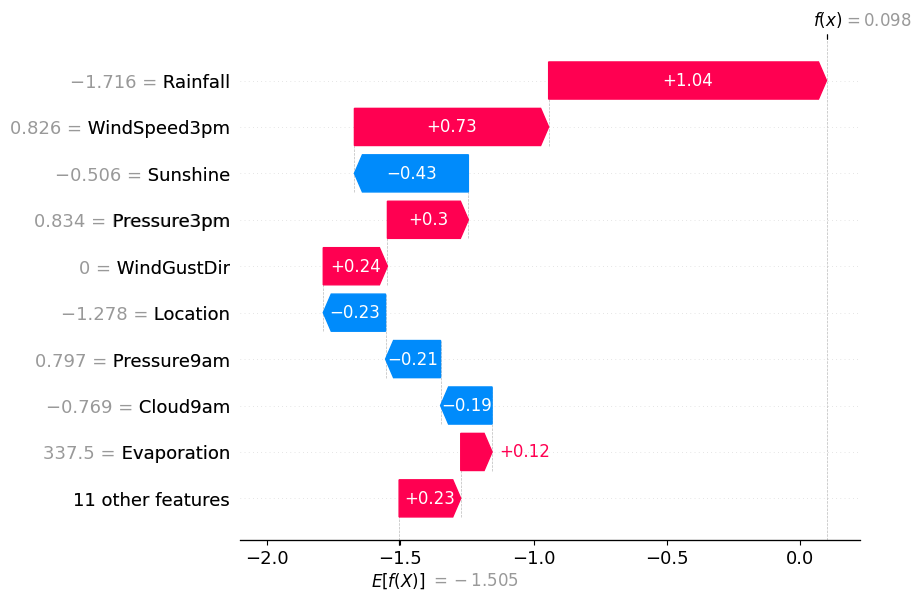

In [113]:
idx = 50

logistica.predict(x_test_clas)[idx]

shap_values_log = explainer_clas(x_test_clas)

explanation = shap.Explanation(values=shap_values_log[idx],
                                base_values=explainer_clas.expected_value,
                                feature_names=x_train_clas.columns)

shap.plots.waterfall(explanation)

## Red para regresión

### Explicabilidad global

Primero probamos con `shap.Explainer` y notamos que tarda mucho (3m 2.4s) en mostrar los resultados ya que no es eficiente esta clase para explicar redes neuronales. Investigamos y vimos que es más eficiente la clase `shap.DeepExplainer` para trabajar con modelos de redes neuronales.

In [114]:
# explainer = shap.Explainer(model_reg,
#                            x_train_regre.values,
#                            feature_names=x_train_regre.columns)

# explanation = explainer(x_test_reg)

# shap.plots.beeswarm(explanation, max_display=None)

Acá vemos que `shap.DeepExplainer` tardo menos (2m 33.8s)

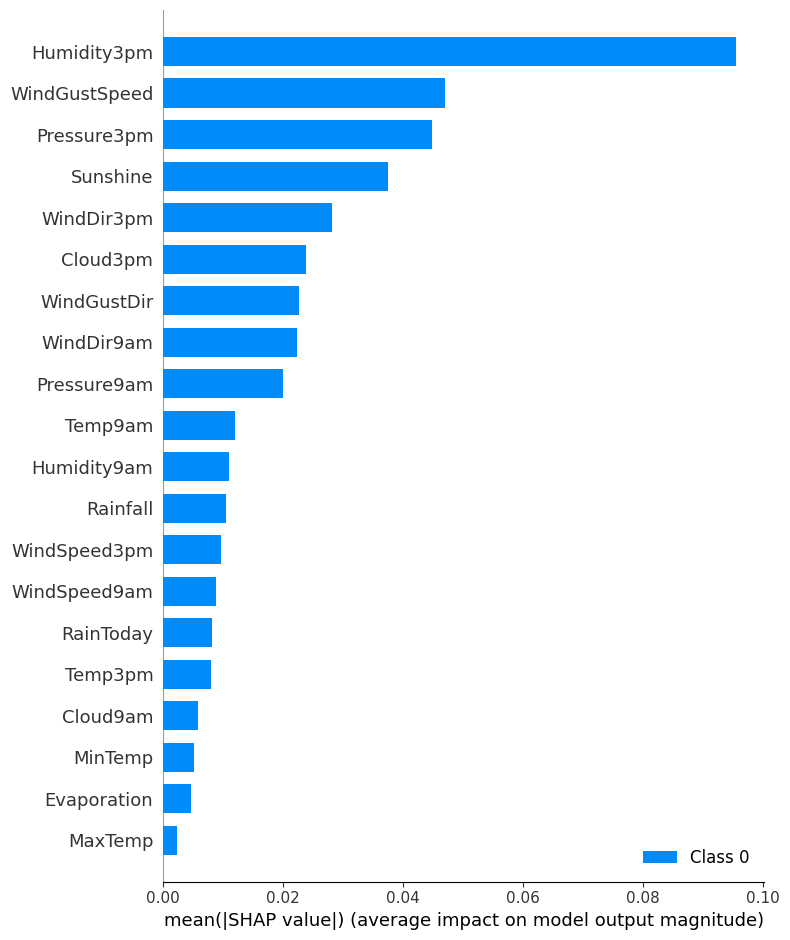

In [115]:
x_train_array = x_train_regre.values
x_test_array = x_test_reg.values

# Crea el explainer usando DeepExplainer
explainer = shap.DeepExplainer(model_reg, x_train_array)

# Obtén las explicaciones para x_test_reg
explanation = explainer.shap_values(x_test_array)

# Plotea el gráfico de beeswarm
shap.summary_plot(explanation, x_test_array, feature_names=x_train_regre.columns)

### Explicabilidad local

No pudimos hacer funcionar la explicabilidad local para las redes neuronales.

In [116]:
# # Convertir DataFrame de pandas a array de NumPy
# x_train_array = x_train_regre.values

# # Crear un objeto DeepExplainer con tu modelo y los datos en formato array
# explainer = shap.DeepExplainer(model_reg, x_train_array)

# # Obtener los SHAP values para el conjunto de test
# shap_values = explainer.shap_values(x_train_array)

In [117]:
# shap.force_plot(explainer.expected_value, explanation[0], x_train_regre.iloc[0, :].values)

In [118]:
# # Elige una instancia específica de x_test_reg para la explicación local (por ejemplo, la primera instancia)
# instance_to_explain = x_test_array[[0]]

# # Obtén las explicaciones para la instancia específica
# explanation_local = explainer.shap_values(instance_to_explain)

# instance_to_explain_np = instance_to_explain.numpy()

# # Obtener las explicaciones para la instancia específica
# explanation_local = explainer.shap_values(instance_to_explain_np)

# # Plotea el gráfico de barras para la explicación local
# shap.force_plot(explainer.expected_value[0], explanation_local[0], instance_to_explain_np, feature_names=x_train_regre.columns)

# # # Plotea el gráfico de barras para la explicación local
# # shap.force_plot(explainer.expected_value[0], explanation_local[0], instance_to_explain, feature_names=x_train_regre.columns)


In [119]:
# shap.initjs()
# shap.force_plot(explainer.expected_value, explanation[0], x_train_regre.iloc[0, :].values)

## Red para clasificación

### Explicabilidad global

In [120]:
# Convertir DataFrame de pandas a array de NumPy
x_train_clasi_array = x_SMOTE.values

# Crear un objeto DeepExplainer con tu modelo y los datos en formato array
explainer = shap.DeepExplainer(model_clas, x_train_clasi_array)

# Obtener los SHAP values para el conjunto de test
shap_values_clasi = explainer.shap_values(x_train_array)

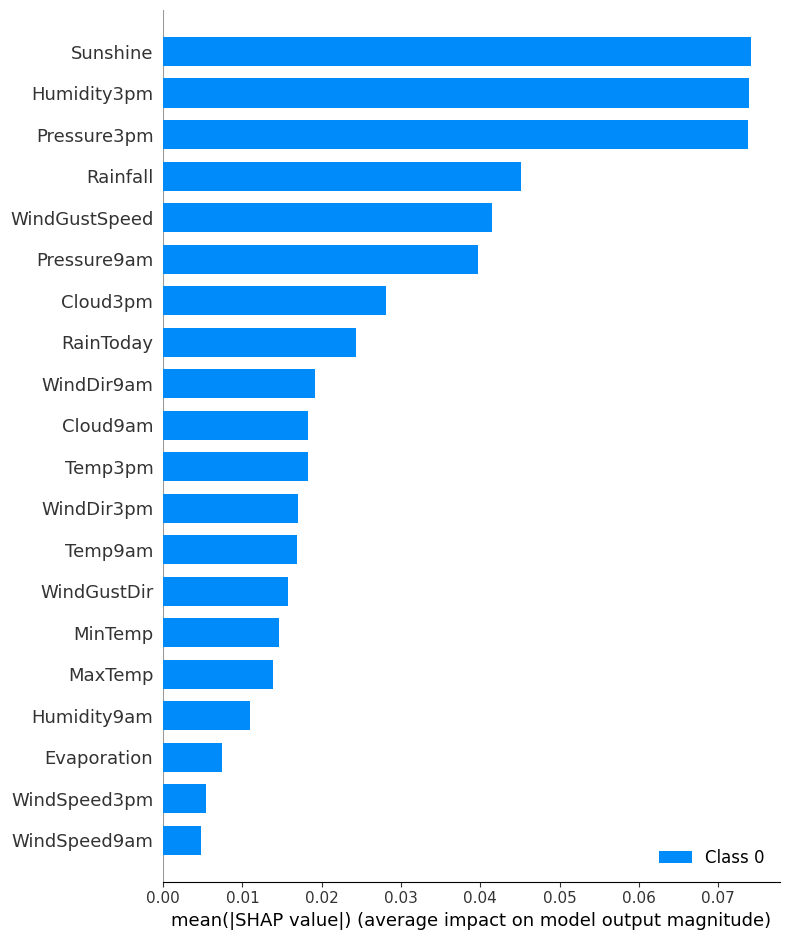

In [121]:
# Obtener la importancia global de las características
shap.summary_plot(
    shap_values_clasi,
    features=x_train_clasi_array,
    feature_names=x_SMOTE.columns)

plt.show()

PermutationExplainer explainer: 3009it [01:31, 30.02it/s]                          


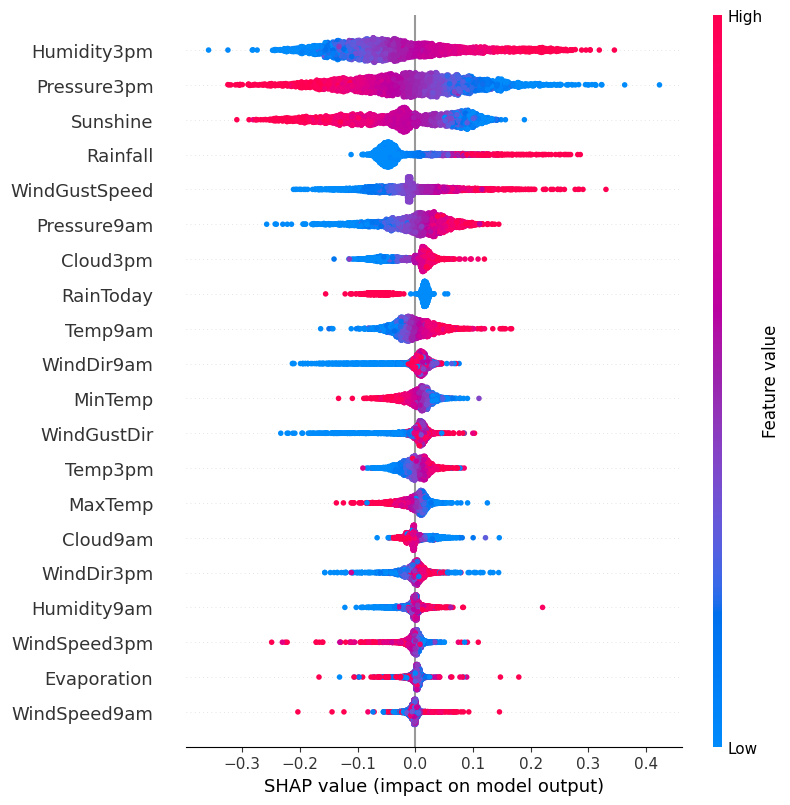

In [122]:
explainer = shap.Explainer(model_clas,
                           x_SMOTE.values,
                           feature_names=x_SMOTE.columns)

explanation = explainer(x_test_clas)

shap.plots.beeswarm(explanation, max_display=None)

Tratamos de hacerlo con `shap.DeepExplainer` pero se pierden los nombres de las columnas, por eso decidimos hacerlo con `shap.Explainer` aunque sea más lento.

In [123]:
# explanation#veo que .values es una lista y tiene que ser un array?
# explanation = shap.Explanation(shap_values, data=x_train_array)
# arrays_lista = explanation.values #todo lo que hago aca es para solucion un error de dimensiones que me daba al quere hacer el plot
# #me di cuenta que values es una lista y tiene que ser un array
# array_completo = np.concatenate(arrays_lista)
# explanation.values = array_completo
# # Suponiendo que x_train es tu DataFrame de datos de entrenamiento
# feature_names = x_train_regre.columns.tolist()

# # Generar el gráfico de abejas de SHAP
# shap.plots.beeswarm(explanation[:, :])

# print(feature_names)

# Producción

Guardamos un dataset imputado para usar los rangos en el front end

In [124]:
df_reg.to_csv('datasets/df_reg.csv')

Creamos el pipeline con los mejores modelos de regresión y clasificación

In [125]:
# cols_dir = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

pipe_reg = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler',  StandardScaler()),
    ('model', model_reg)
])

pipe_reg.fit(x_train_regre, y_train_reg)

joblib.dump(pipe_reg, 'models/regresion_pipeline.joblib')

376/376 [==============================] - 1s 1ms/step - loss: 38.1837 - mean_squared_error: 38.1837


['models/regresion_pipeline.joblib']

In [126]:
pipe_clas = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler',  StandardScaler()),
    ('model', LogisticRegression())
])

pipe_clas.fit(x_SMOTE, y_SMOTE)

joblib.dump(pipe_clas, 'models/clasificacion_pipeline.joblib')

['models/clasificacion_pipeline.joblib']

# Conclusiones finales